In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
from fooof import FOOOF
import functools
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as pq

import epych
from epych.statistics import alignment, spectrum

/tmp/ipykernel_658374/3643940196.py:2: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF
[striatum:658374] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/665714688/shared_mem_cuda_pool.striatum could be created.
[striatum:658374] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
OFFSET = pq.Quantity(0.25) * pq.second
EVENTS = {
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]
CONTRASTS = [("go_contrast", "go_gloexp", "go_seqctl"), ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

In [8]:
CONDITION_TITLES = {
    "lonaive": "AAAB (first 50)",
    "go_gloexp": "AAAA global oddball",
    "go_seqctl": "AAAA control",
    "lo_gloexp": "AAAB local oddball",
    "lo_rndctl": "AAAB control",
    "igo_seqctl": "BBBB control",
}

In [9]:
AREA_TITLES = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in AREA_TITLES:
        return AREA_TITLES[name]
    return name
ANATOMICAL_AREAS = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [10]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [11]:
FREQ_RANGE = (1, 150)

In [12]:
spectrograms = {}

In [13]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample8x2_%s" % cond
    spectrograms[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram).results()
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


In [14]:
def fooof_stimulus_report(cond, area, stim="Adapted"):
    if stim == "Adapted":
        onset, offset = ADAPTED_ONSET, ADAPTED_OFFSET
    elif stim == "Oddball":
        onset, offset = ODDBALL_ONSET, ODDBALL_OFFSET
    spec = spectrograms[cond].signals[area][(onset - OFFSET).magnitude:(offset + OFFSET).magnitude].power_spectrum()
    fm = FOOOF(verbose=False, aperiodic_mode="knee")
    fm.report(spec.freqs, spec.data.magnitude.mean(0).mean(-1), FREQ_RANGE)
    plt.title("%s spectrum (%s, %s)" % (stim, AREA_TITLES[area], CONDITION_TITLES[cond]))
    os.makedirs("fooofs/%s/%s/" % (cond, area), exist_ok=True)
    plt.savefig("fooofs/%s/%s/oddball.pdf" % (cond, area))
    plt.show()

    fm.get_params('aperiodic_params', 'knee')

In [15]:
def fooof_report(cond, area):
    spec = spectrograms[cond].signals[area].power_spectrum()
    fm = FOOOF(verbose=False, aperiodic_mode="knee")
    fm.report(spec.freqs, spec.data.magnitude.mean(0).mean(-1), FREQ_RANGE)
    plt.title("Full-trial spectrum (%s, %s)" % (AREA_TITLES[area], CONDITION_TITLES[cond]))
    os.makedirs("fooofs/%s/%s/" % (cond, area), exist_ok=True)
    plt.savefig("fooofs/%s/%s/trial.pdf" % (cond, area))
    plt.show()
    
    fm.get_params('aperiodic_params', 'knee')

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1924, 10.3324, 1.7999                                     
                                                                                                  
                                       4 peaks were found:                                        
          

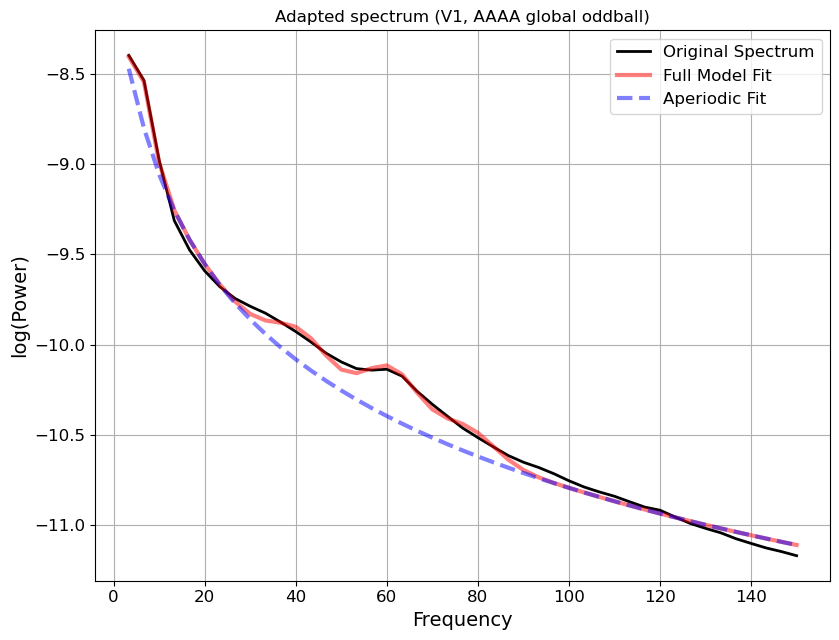

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1984, 9.9696, 1.8019                                      
                                                                                                  
                                       5 peaks were found:                                        
          

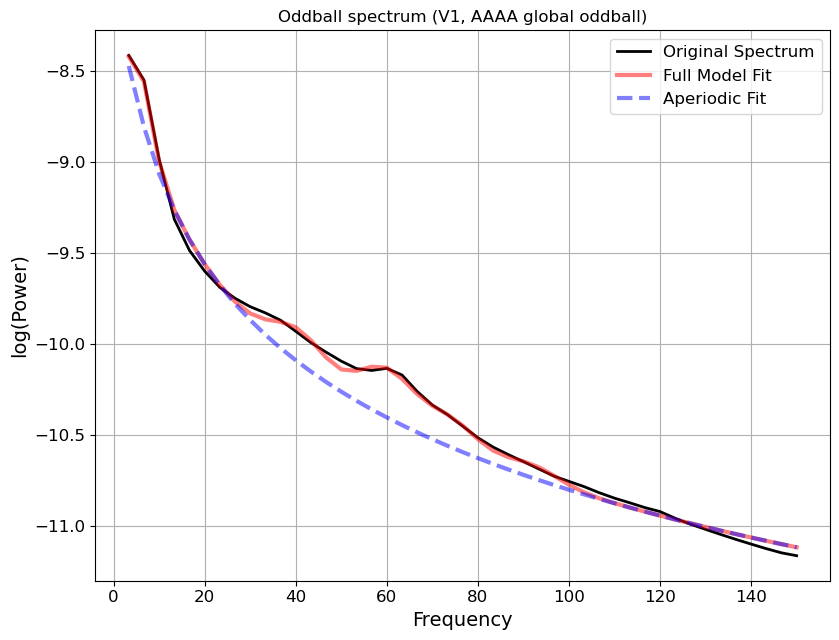

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0464, 5.8043, 1.8701                                      
                                                                                                  
                                       4 peaks were found:                                        
          

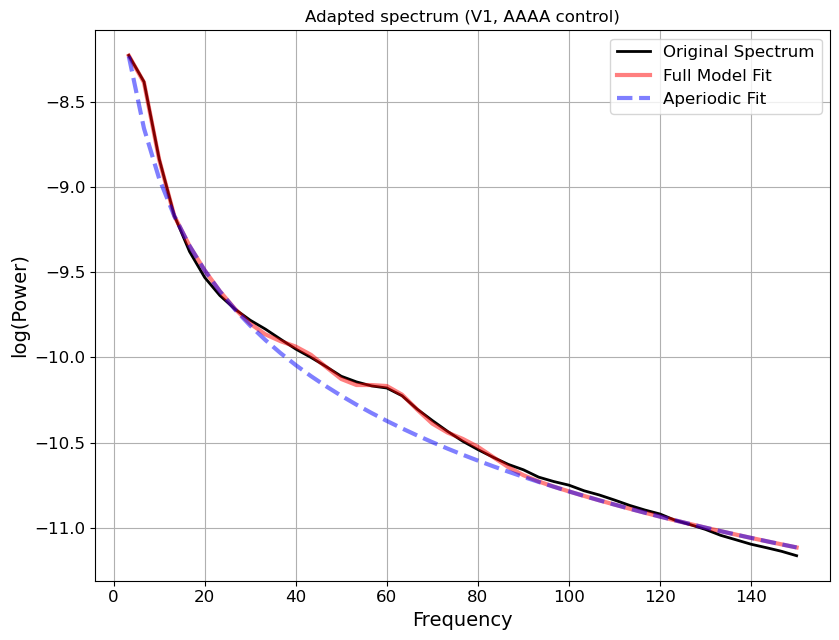

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0972, 4.9919, 1.8450                                      
                                                                                                  
                                       4 peaks were found:                                        
          

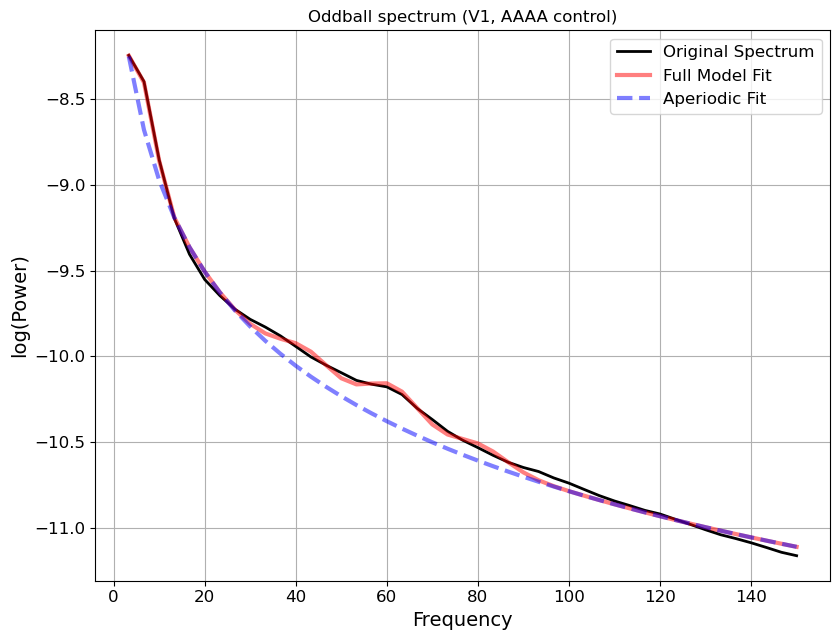

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2288, 11.4424, 1.7827                                     
                                                                                                  
                                       4 peaks were found:                                        
          

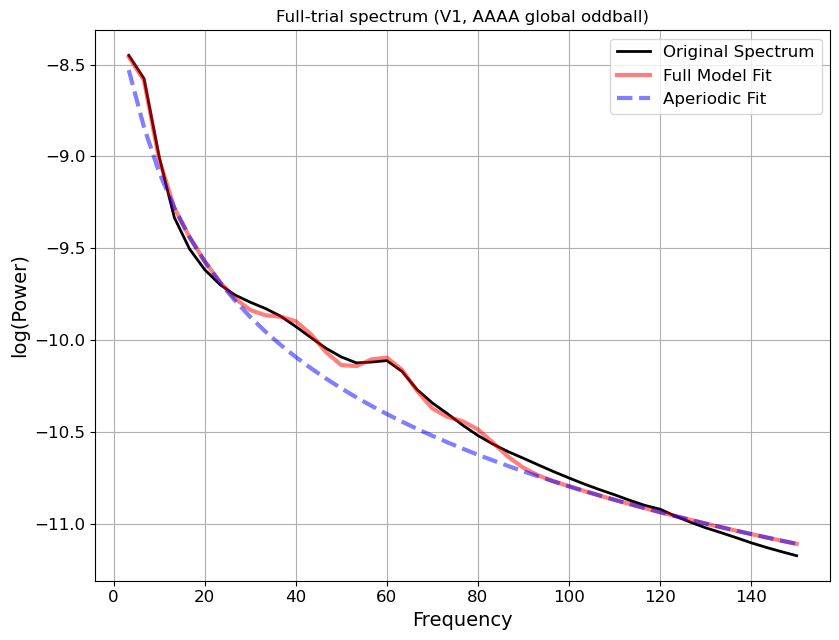

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1125, 5.6069, 1.8397                                      
                                                                                                  
                                       4 peaks were found:                                        
          

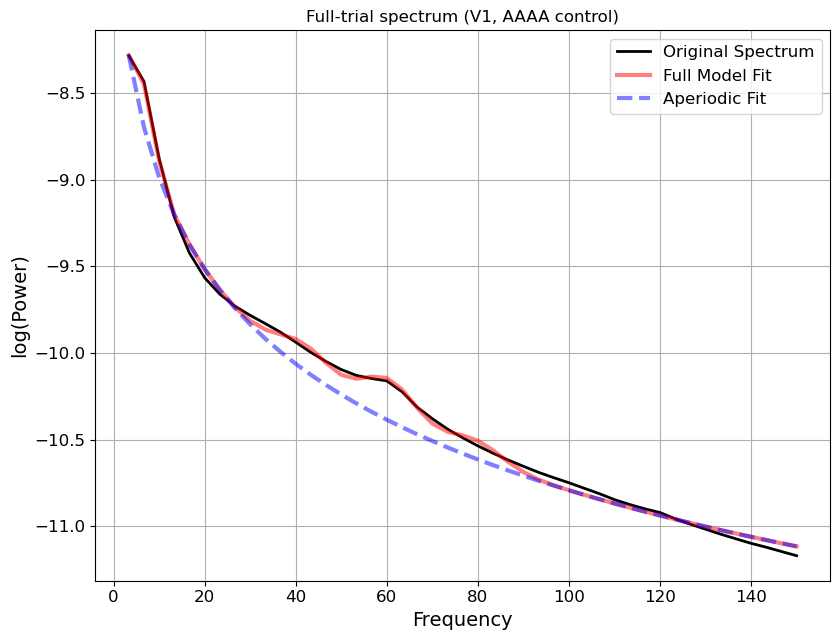

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9967, 12.2285, 1.8405                                     
                                                                                                  
                                       1 peaks were found:                                        
          

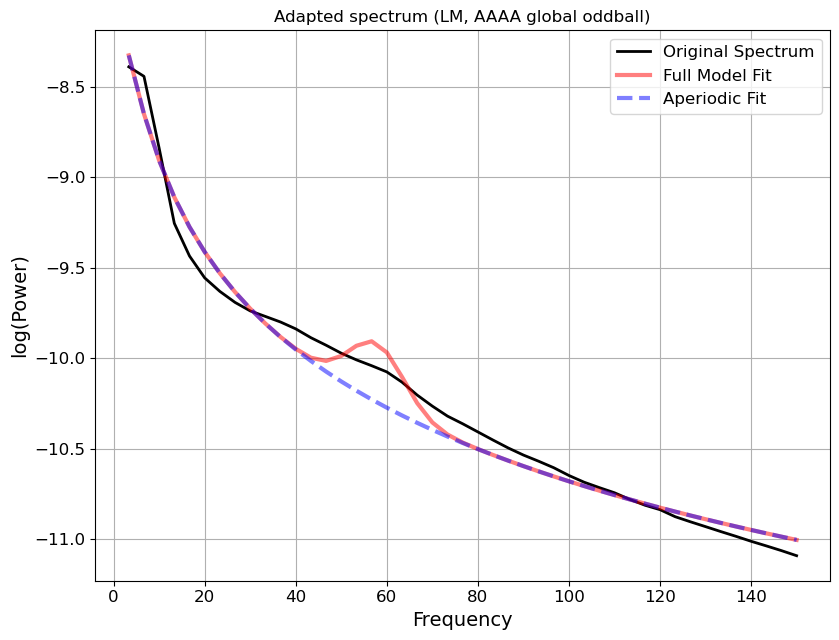

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1029, 7.8544, 1.7966                                      
                                                                                                  
                                       2 peaks were found:                                        
          

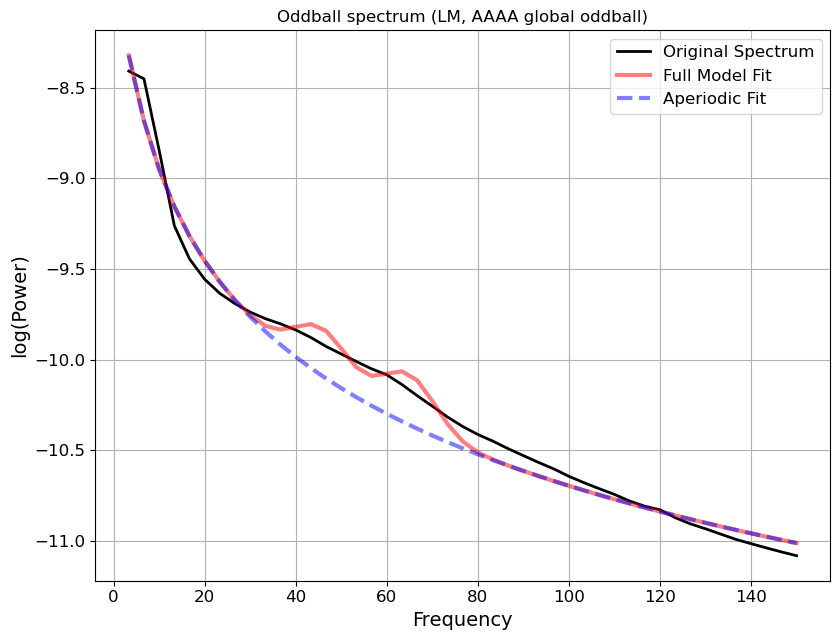

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9747, 8.5947, 1.8554                                      
                                                                                                  
                                       1 peaks were found:                                        
          

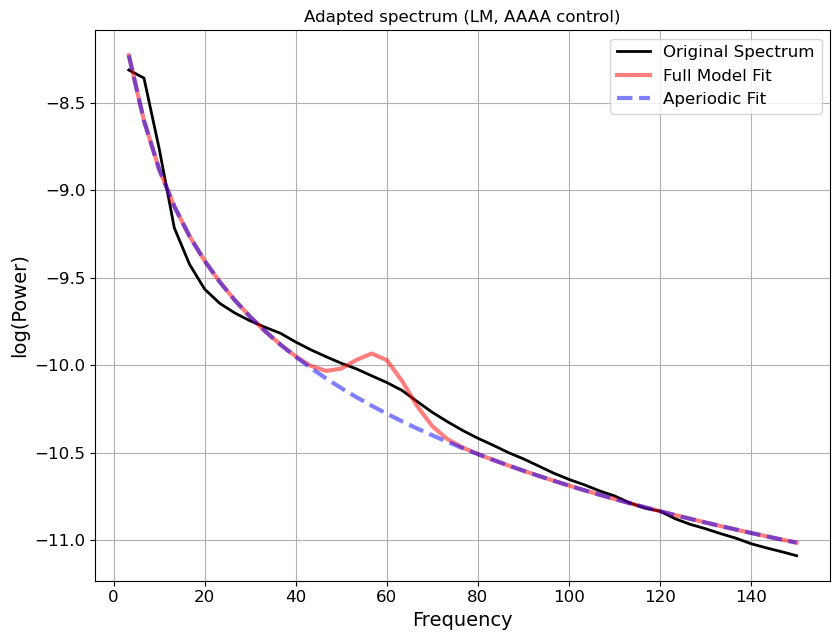

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0074, 7.9993, 1.8391                                      
                                                                                                  
                                       1 peaks were found:                                        
          

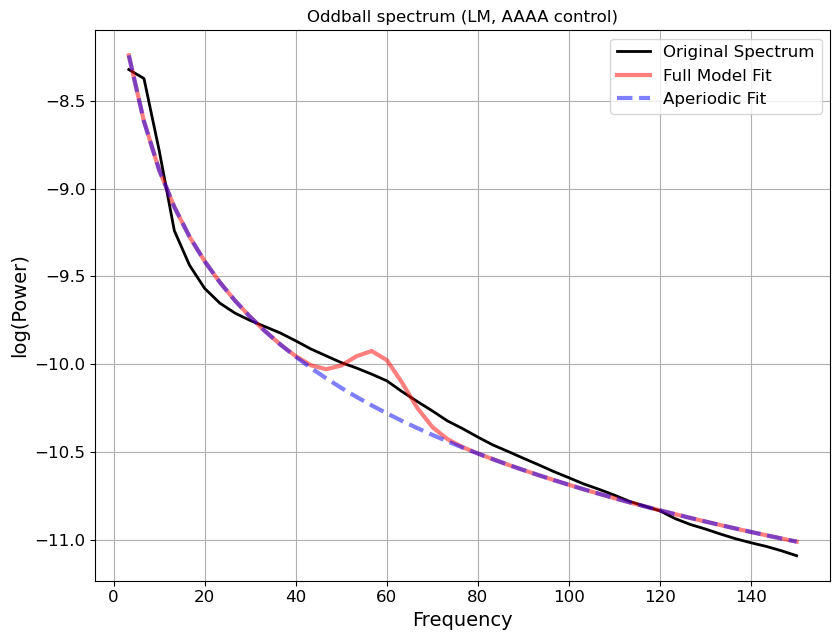

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1040, 8.1743, 1.8002                                      
                                                                                                  
                                       2 peaks were found:                                        
          

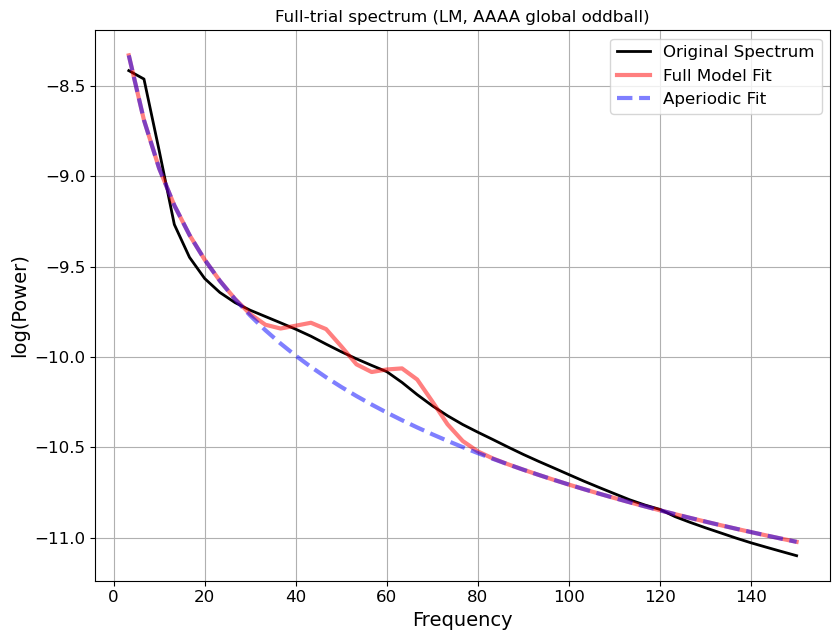

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9882, 9.2346, 1.8515                                      
                                                                                                  
                                       1 peaks were found:                                        
          

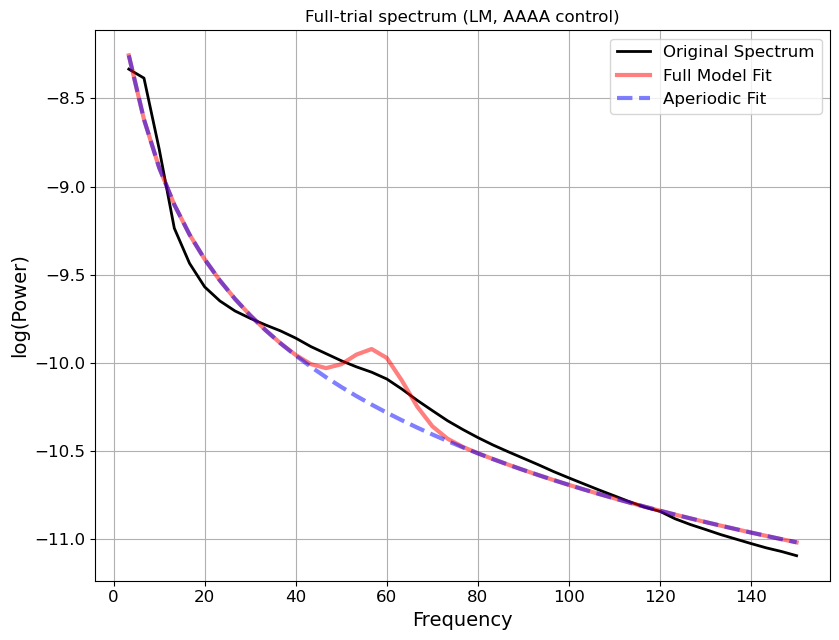

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8160, 18.7343, 1.9898                                     
                                                                                                  
                                       0 peaks were found:                                        
          

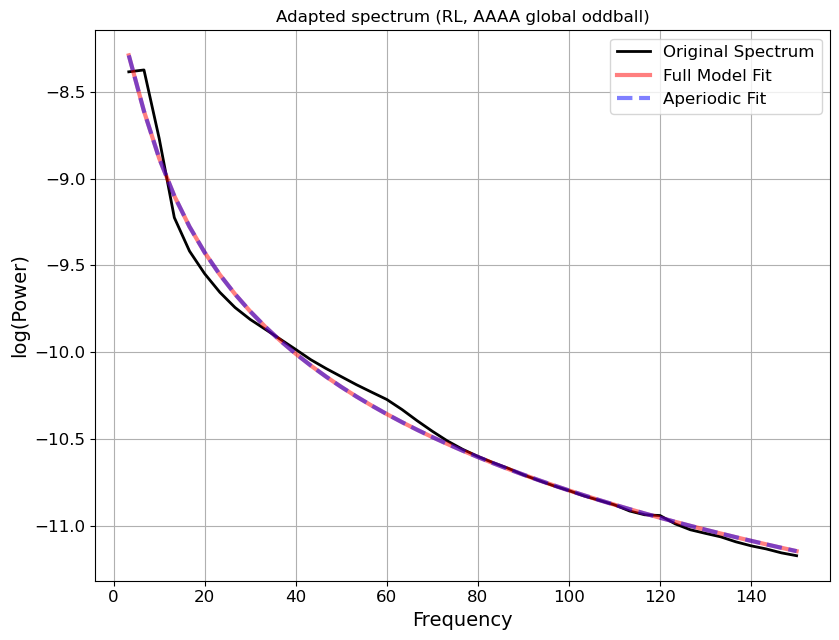

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8252, 18.2936, 1.9835                                     
                                                                                                  
                                       0 peaks were found:                                        
          

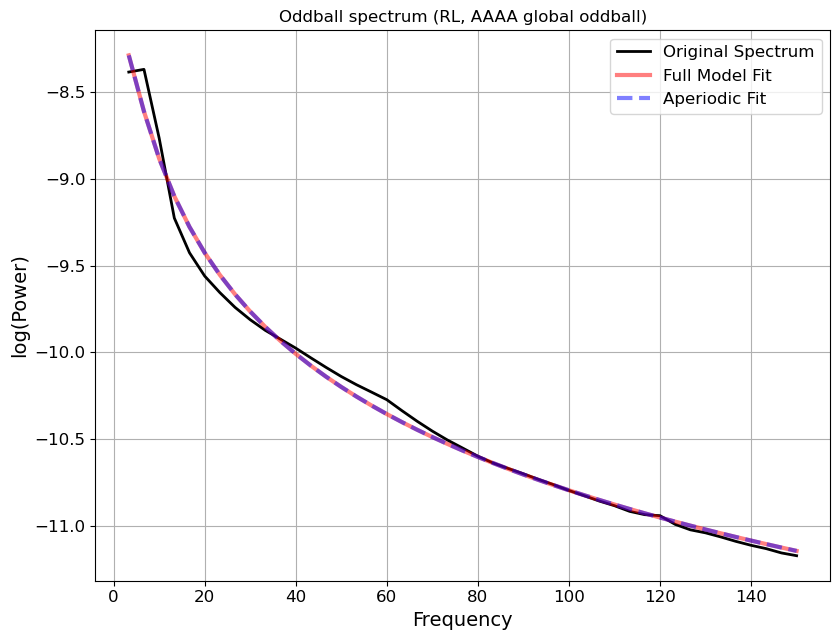

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8056, 10.3322, 1.9862                                     
                                                                                                  
                                       0 peaks were found:                                        
          

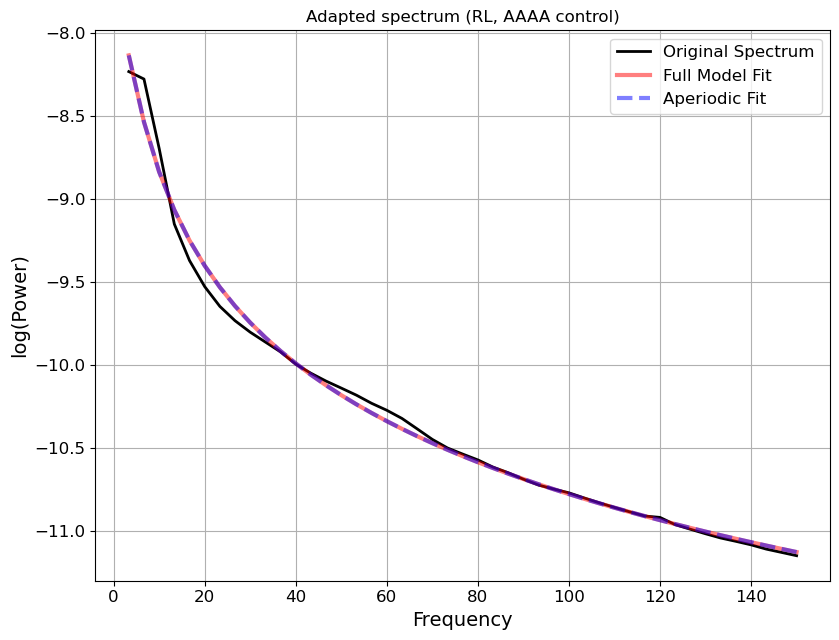

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8195, 10.8224, 1.9795                                     
                                                                                                  
                                       0 peaks were found:                                        
          

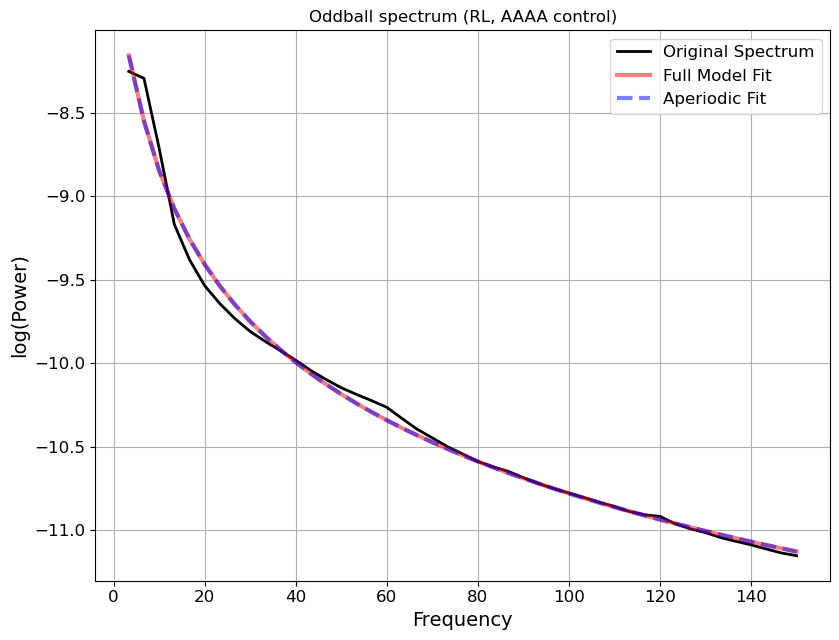

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8144, 19.6839, 1.9933                                     
                                                                                                  
                                       0 peaks were found:                                        
          

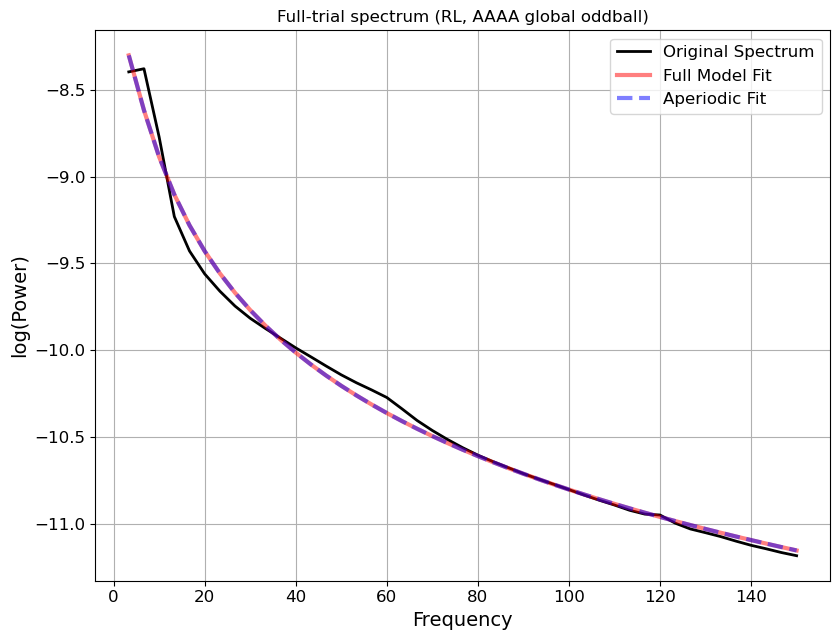

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8047, 11.4307, 1.9891                                     
                                                                                                  
                                       0 peaks were found:                                        
          

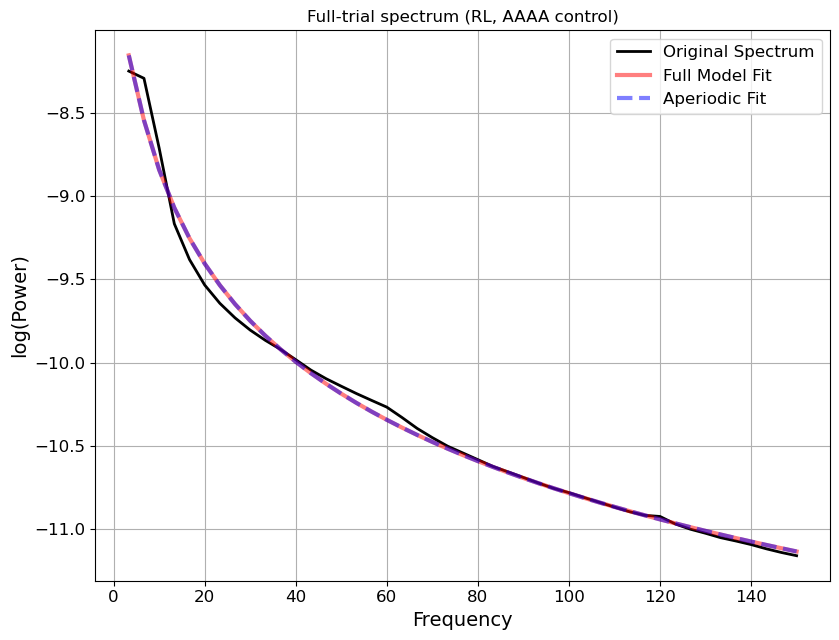

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0780, 15.0750, 1.9132                                     
                                                                                                  
                                       1 peaks were found:                                        
          

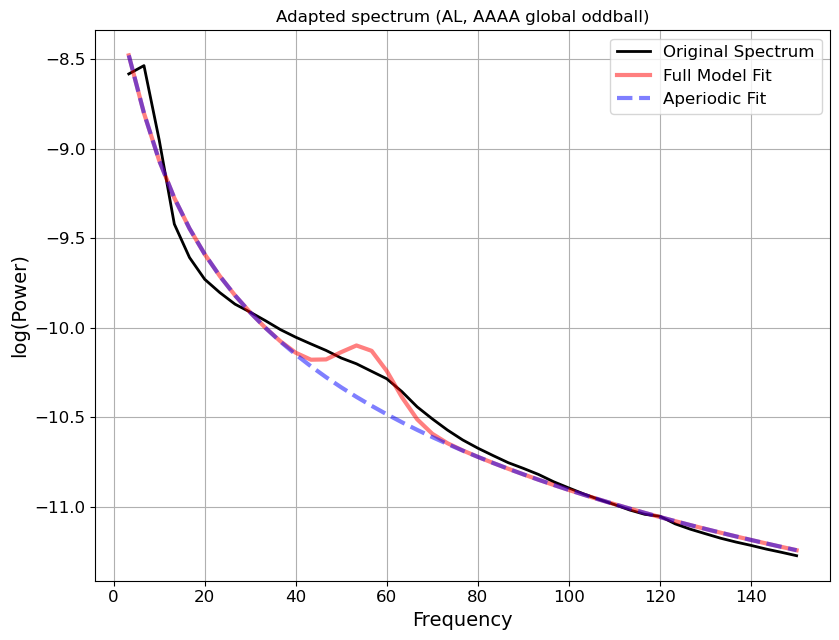

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0891, 15.0834, 1.9057                                     
                                                                                                  
                                       1 peaks were found:                                        
          

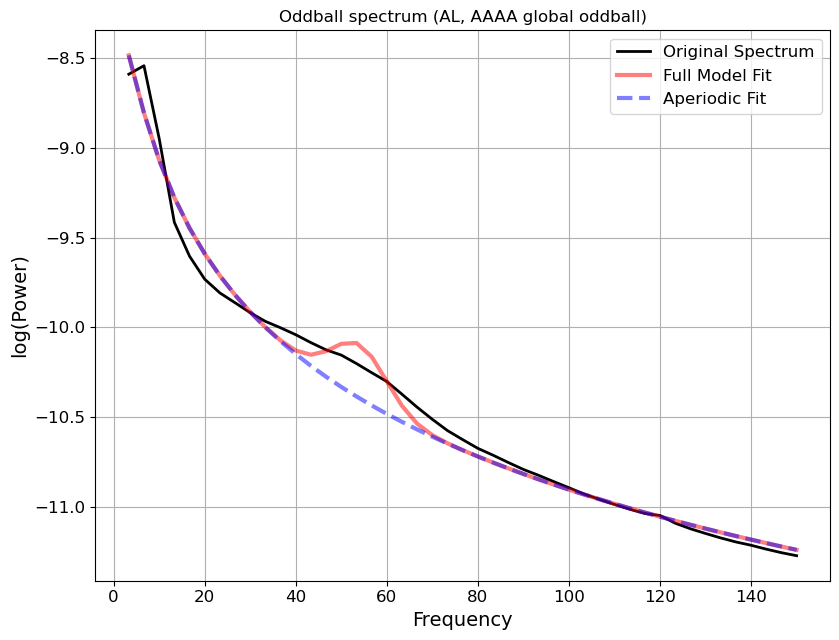

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8896, 18.0326, 1.9866                                     
                                                                                                  
                                       0 peaks were found:                                        
          

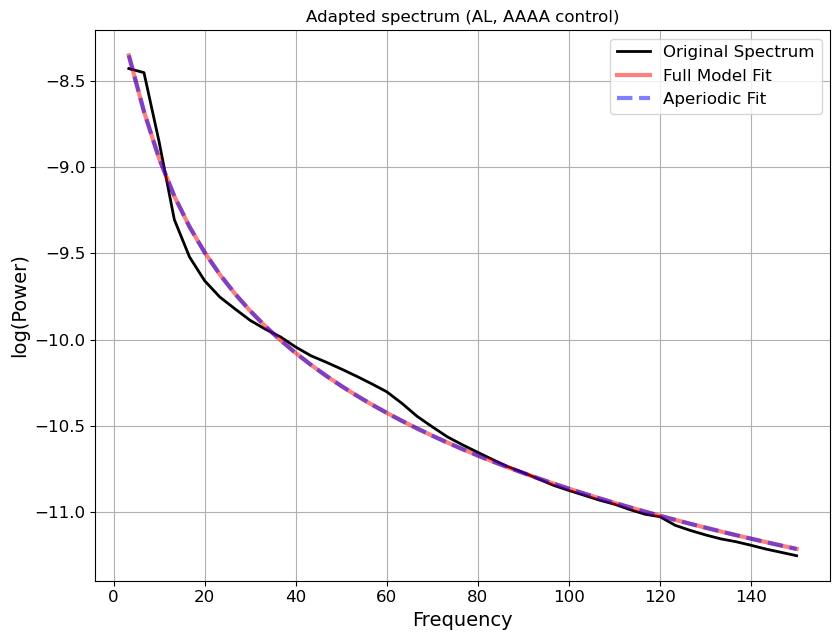

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9550, 13.6121, 1.9668                                     
                                                                                                  
                                       1 peaks were found:                                        
          

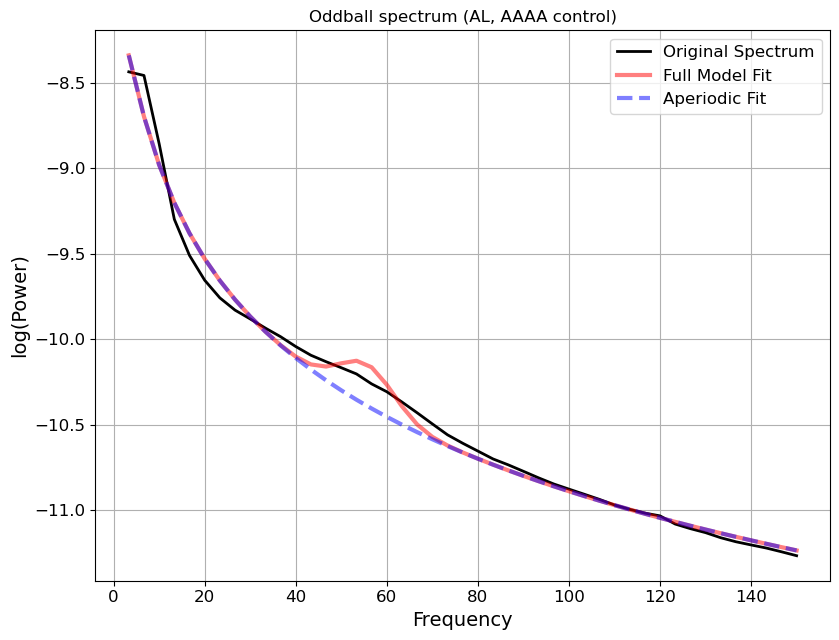

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0805, 16.4037, 1.9155                                     
                                                                                                  
                                       1 peaks were found:                                        
          

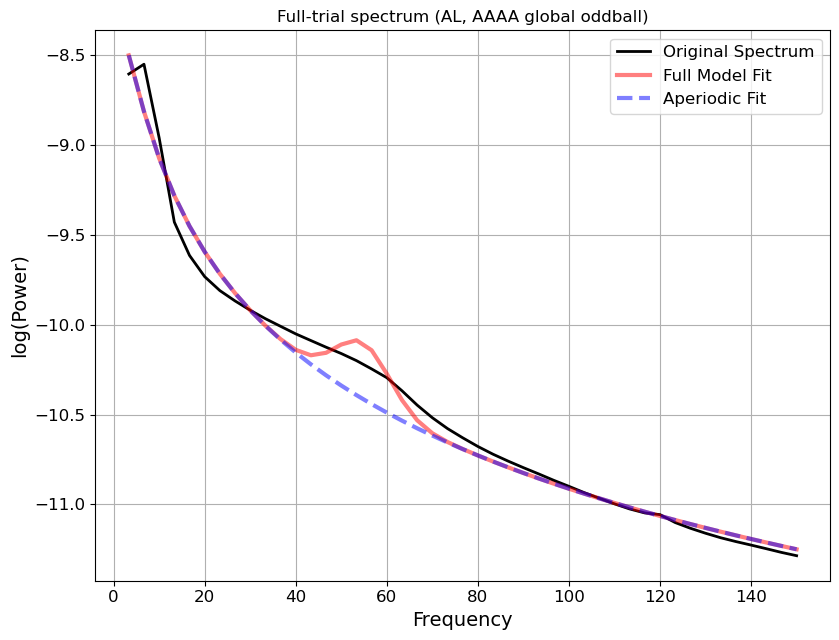

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8784, 21.2227, 1.9956                                     
                                                                                                  
                                       0 peaks were found:                                        
          

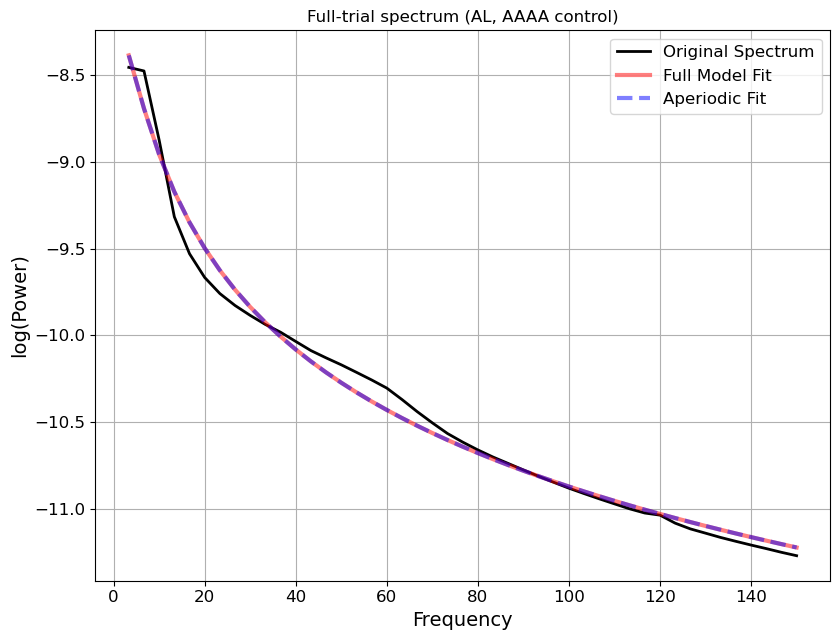

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1069, 16.1735, 1.9086                                     
                                                                                                  
                                       2 peaks were found:                                        
          

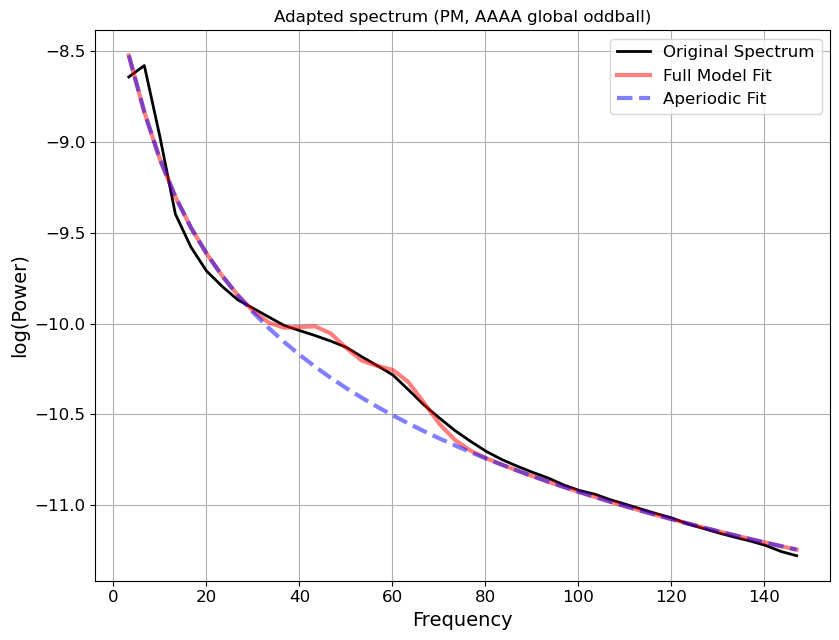

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0501, 21.7286, 1.9306                                     
                                                                                                  
                                       1 peaks were found:                                        
          

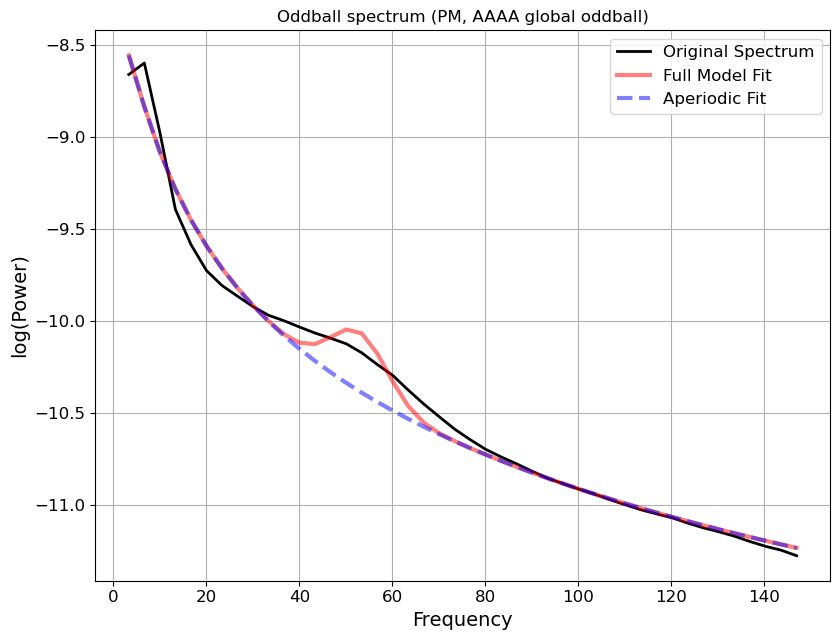

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9199, 18.7334, 2.0091                                     
                                                                                                  
                                       1 peaks were found:                                        
          

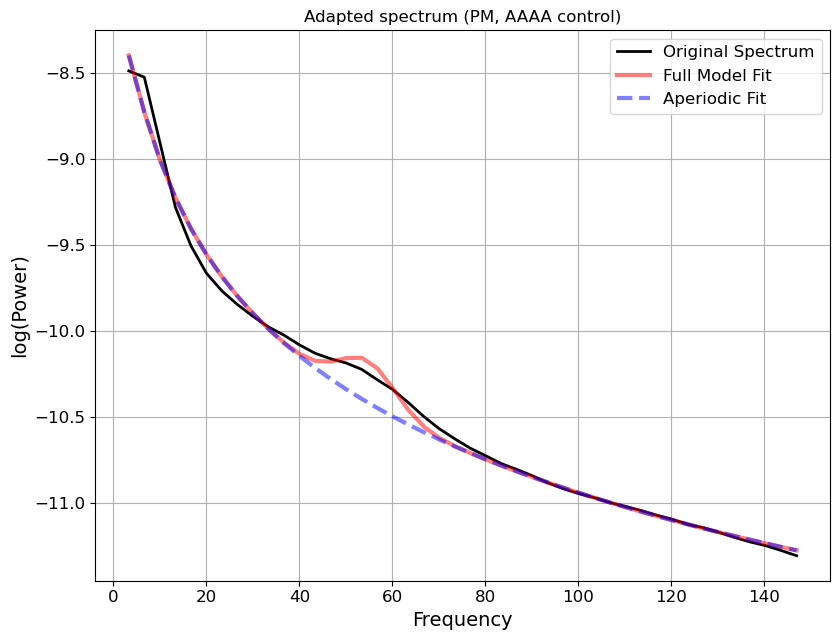

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9411, 18.8741, 1.9972                                     
                                                                                                  
                                       1 peaks were found:                                        
          

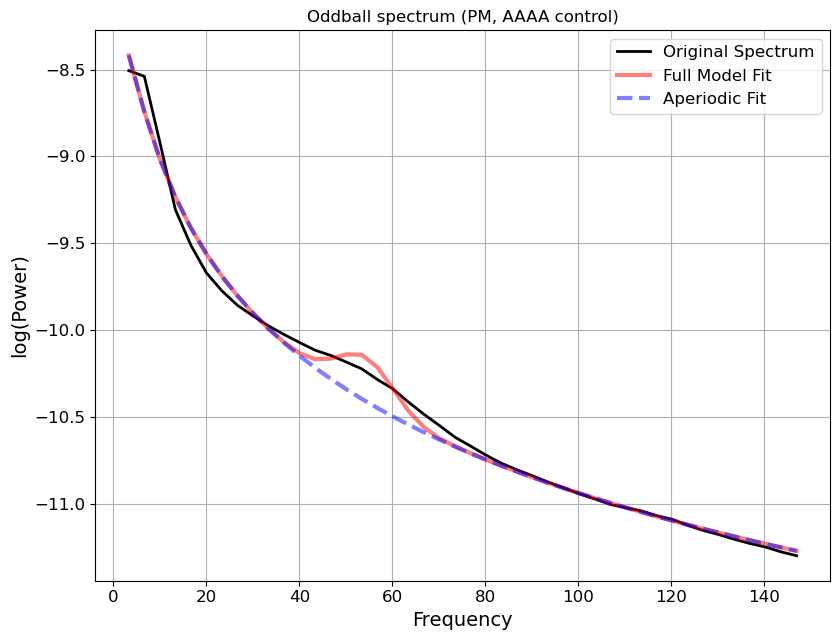

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0499, 22.8336, 1.9321                                     
                                                                                                  
                                       1 peaks were found:                                        
          

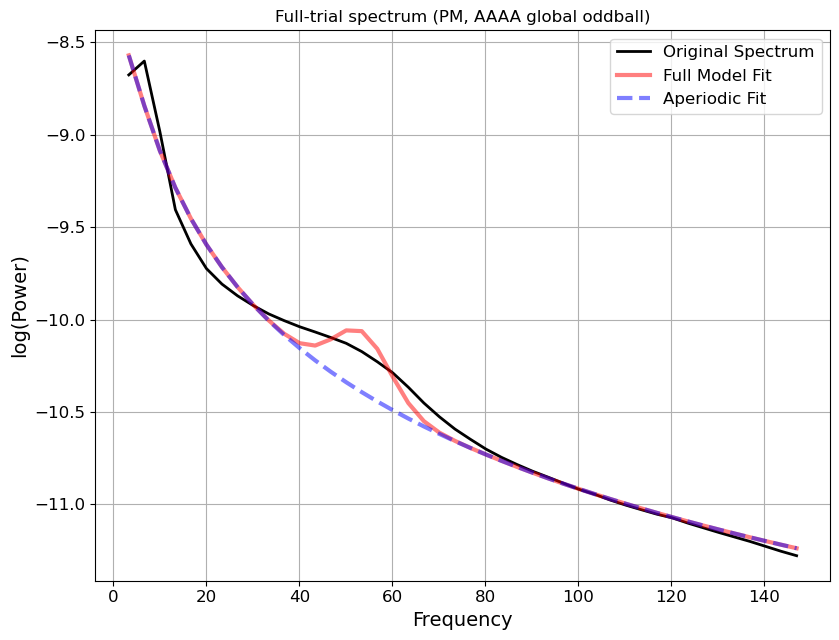

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9332, 19.9287, 2.0028                                     
                                                                                                  
                                       1 peaks were found:                                        
          

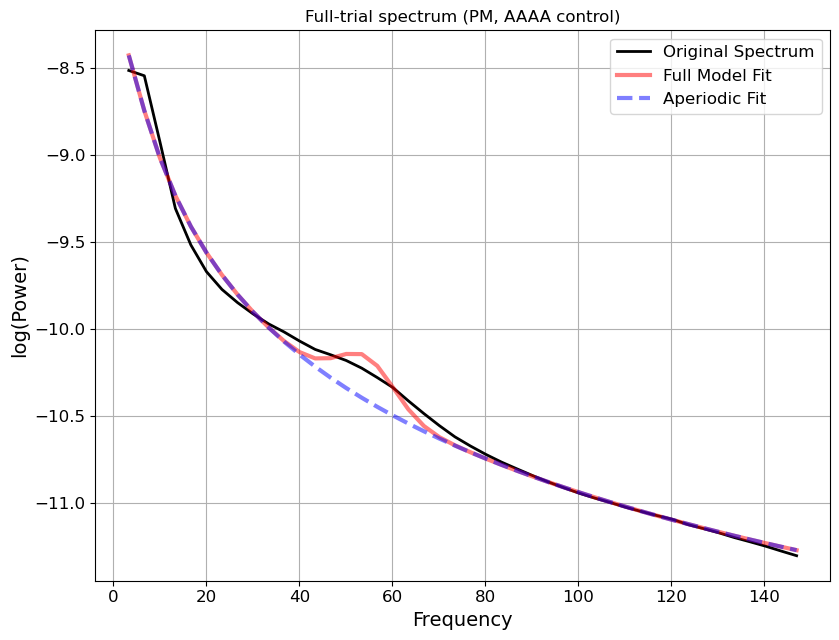

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7901, 30.4308, 2.0200                                     
                                                                                                  
                                       1 peaks were found:                                        
          

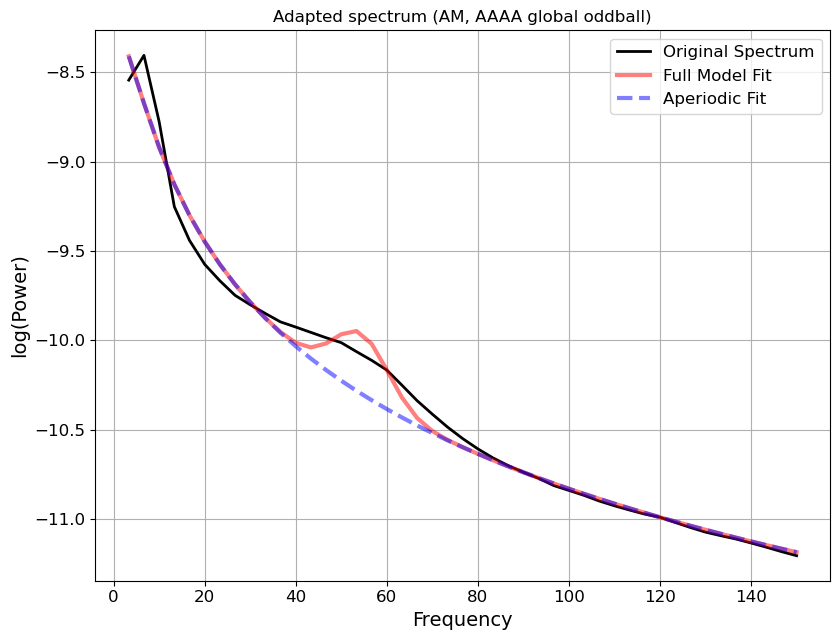

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8115, 29.6372, 2.0073                                     
                                                                                                  
                                       1 peaks were found:                                        
          

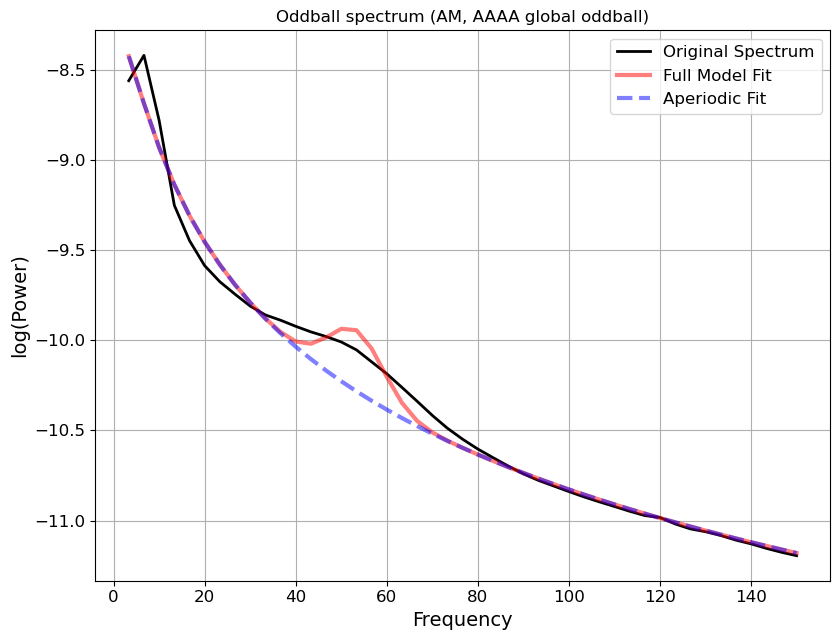

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7076, 25.3587, 2.0725                                     
                                                                                                  
                                       1 peaks were found:                                        
          

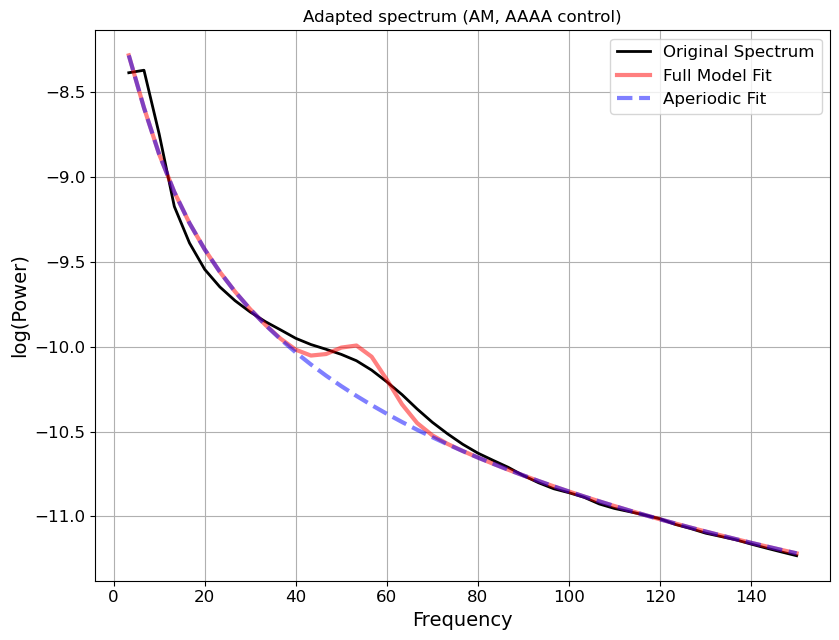

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7110, 27.0201, 2.0703                                     
                                                                                                  
                                       1 peaks were found:                                        
          

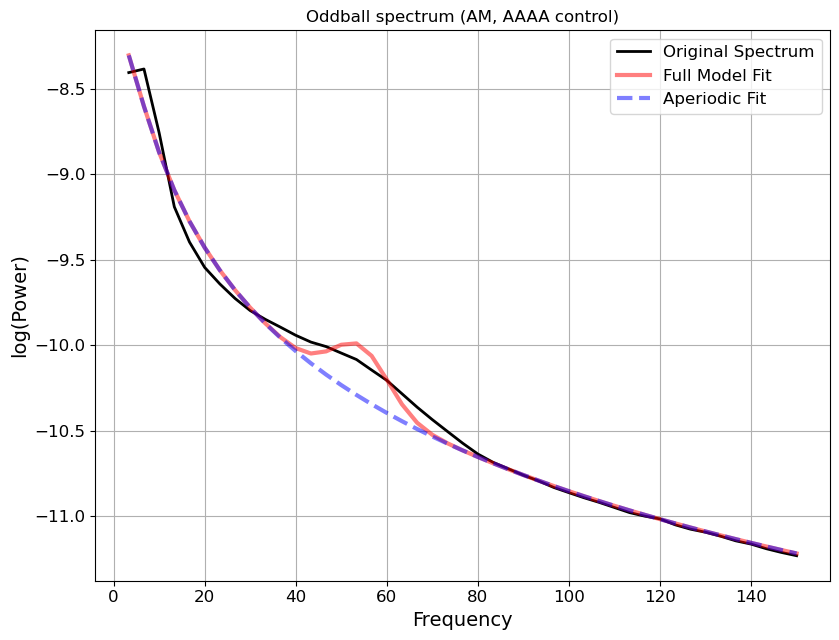

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISam


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7961, 32.0022, 2.0200                                     
                                                                                                  
                                       1 peaks were found:                                        
          

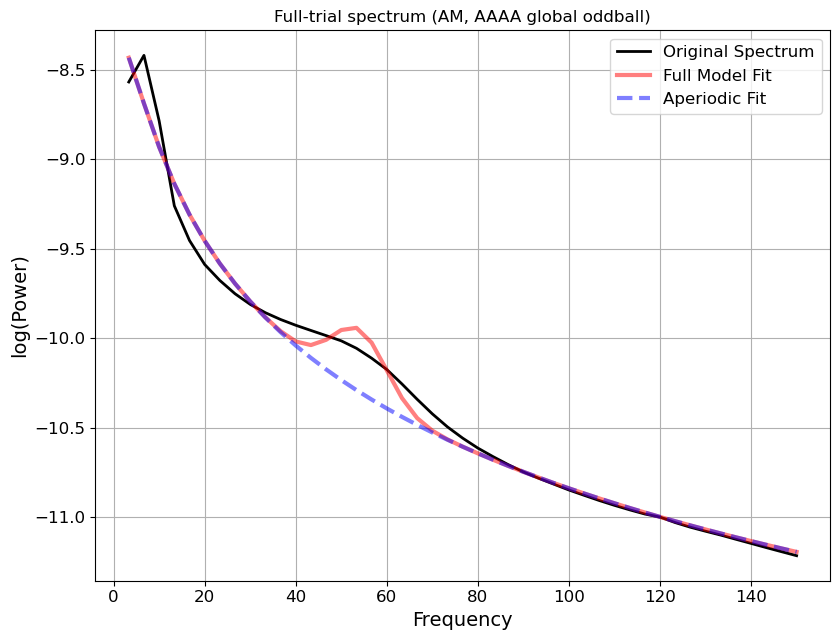

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7086, 27.2398, 2.0730                                     
                                                                                                  
                                       1 peaks were found:                                        
          

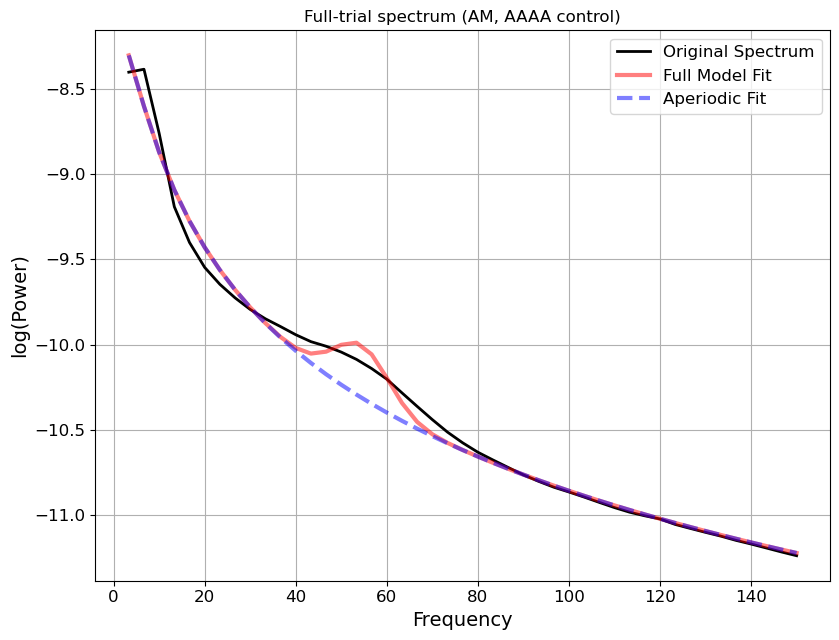

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISam
INFO:root:Applied FOOOF analysis to evoked power spectra for go_contrast


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1781, 11.4403, 1.8108                                     
                                                                                                  
                                       5 peaks were found:                                        
          

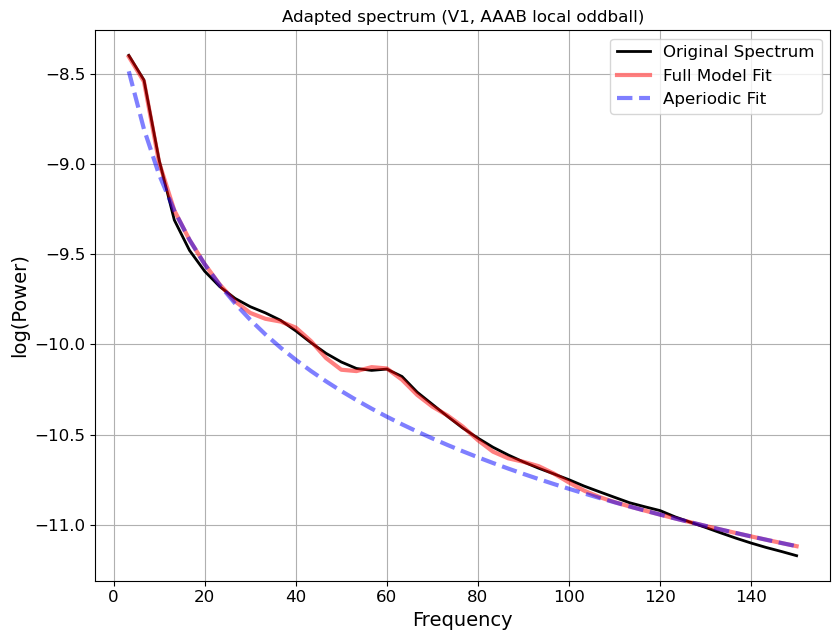

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7047, 23.1314, 2.0118                                     
                                                                                                  
                                       4 peaks were found:                                        
          

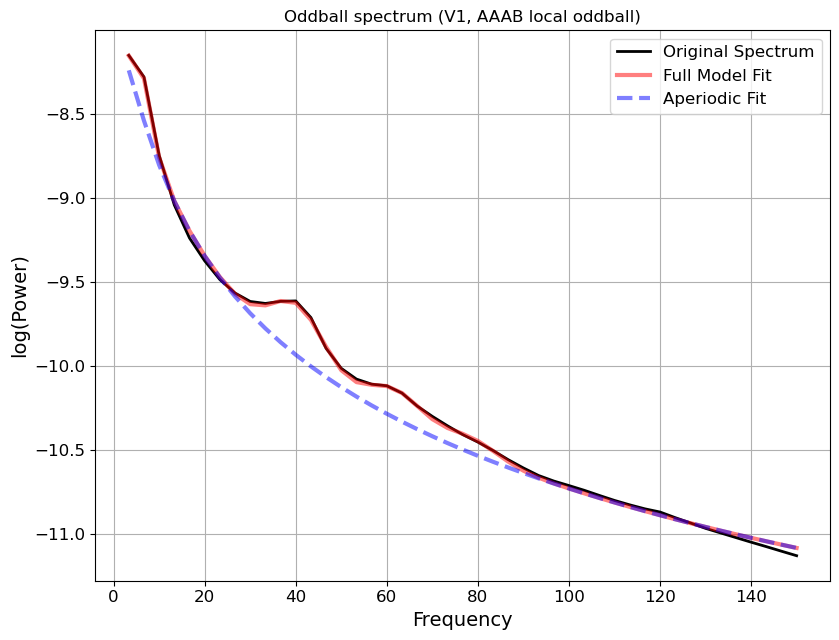

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8553, 8.7260, 1.9634                                      
                                                                                                  
                                       3 peaks were found:                                        
          

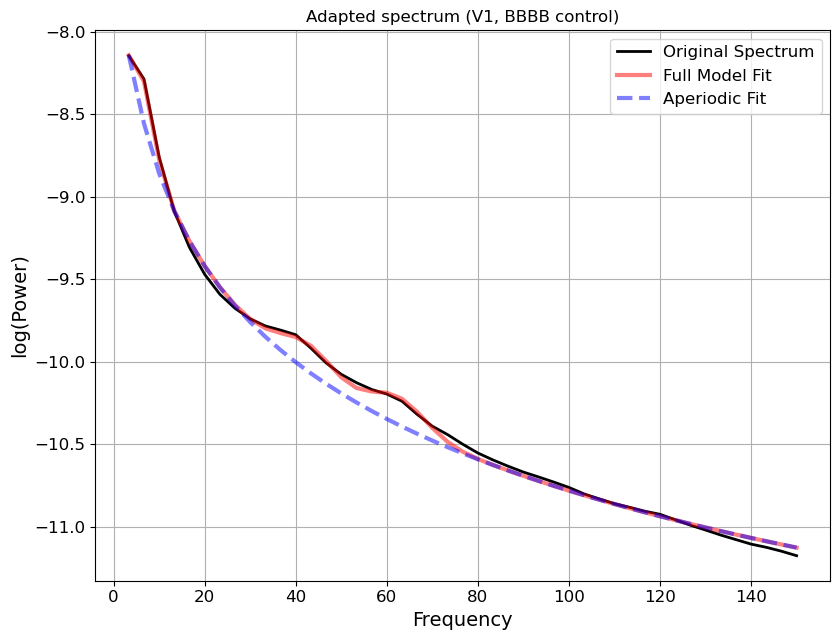

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9224, 7.1880, 1.9313                                      
                                                                                                  
                                       3 peaks were found:                                        
          

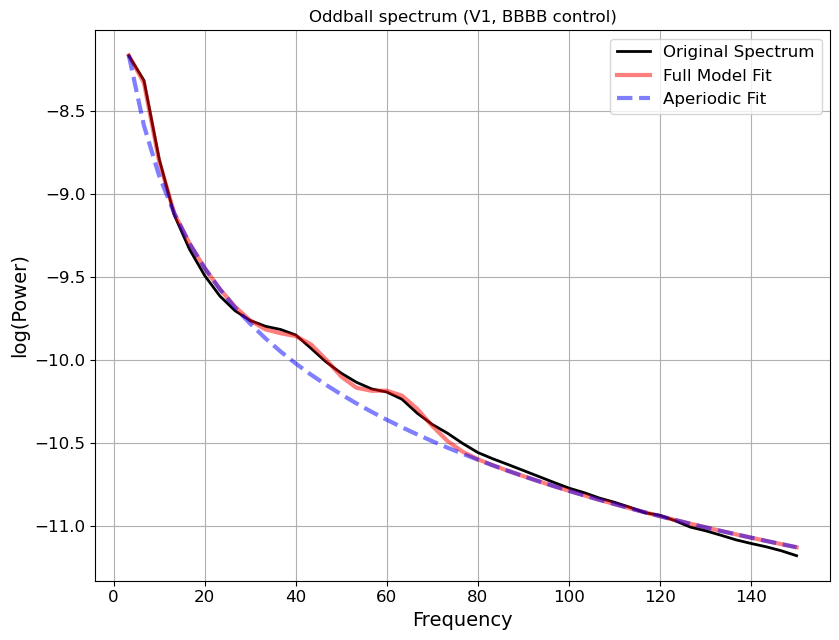

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0569, 10.0150, 1.8645                                     
                                                                                                  
                                       4 peaks were found:                                        
          

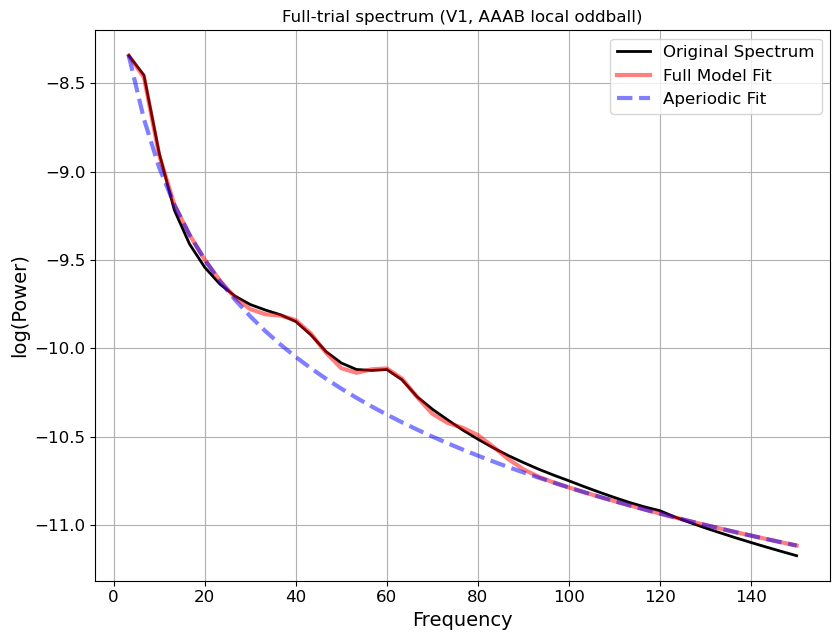

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9448, 7.7311, 1.9191                                      
                                                                                                  
                                       3 peaks were found:                                        
          

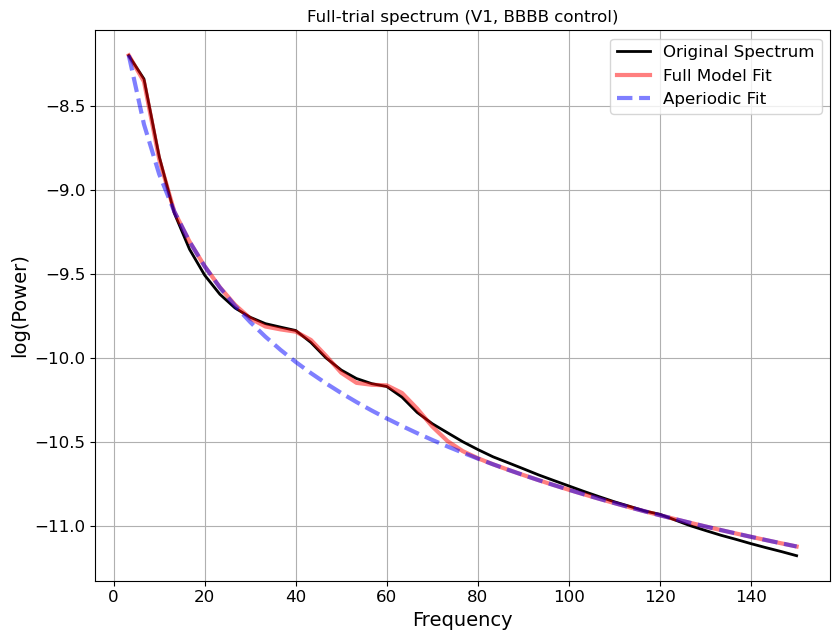

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9986, 11.8531, 1.8402                                     
                                                                                                  
                                       1 peaks were found:                                        
          

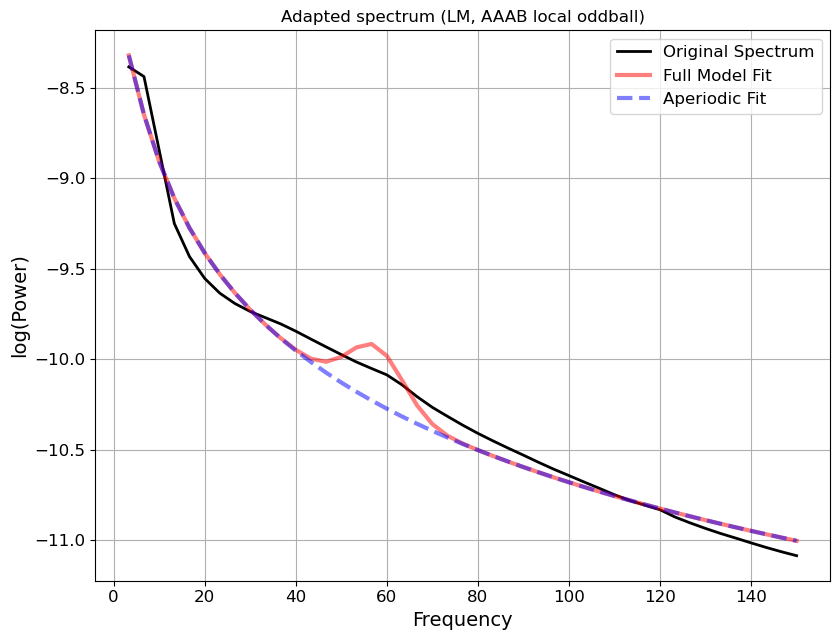

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8740, 9.9689, 1.8943                                      
                                                                                                  
                                       3 peaks were found:                                        
          

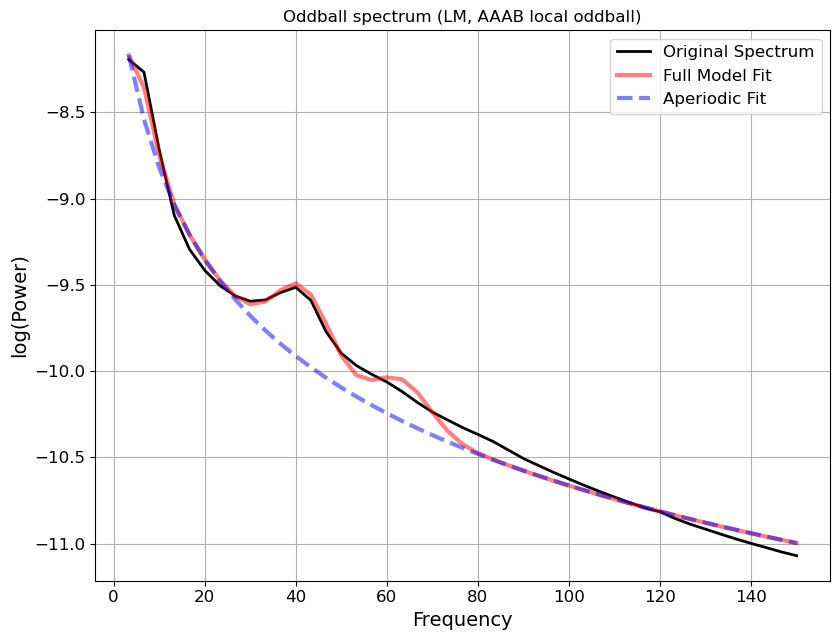

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8247, 13.3187, 1.9100                                     
                                                                                                  
                                       0 peaks were found:                                        
          

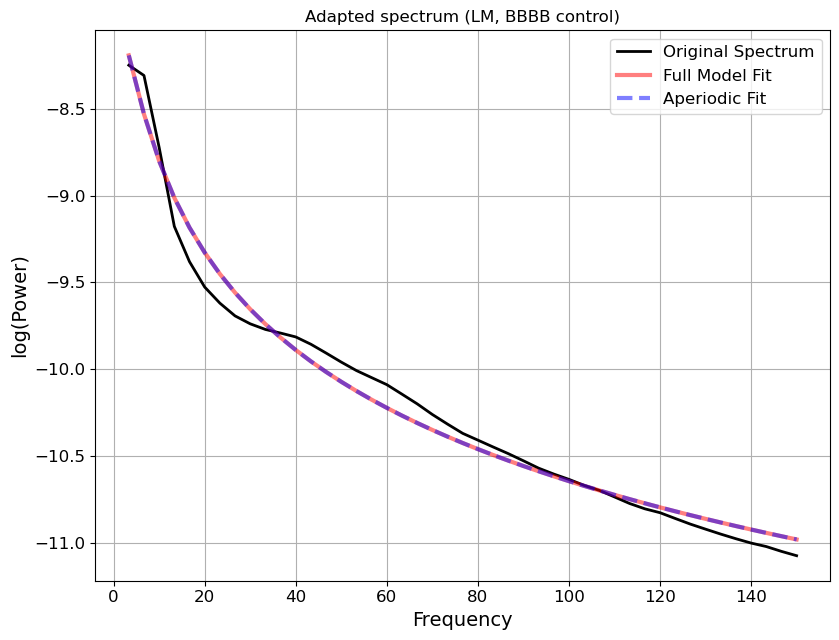

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0418, 4.1596, 1.8243                                      
                                                                                                  
                                       2 peaks were found:                                        
          

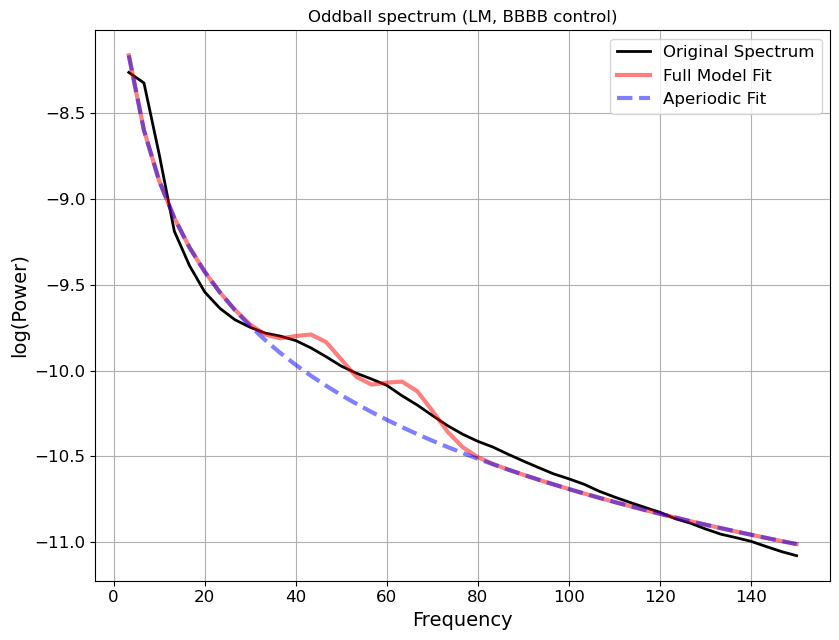

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0272, 7.6875, 1.8374                                      
                                                                                                  
                                       2 peaks were found:                                        
          

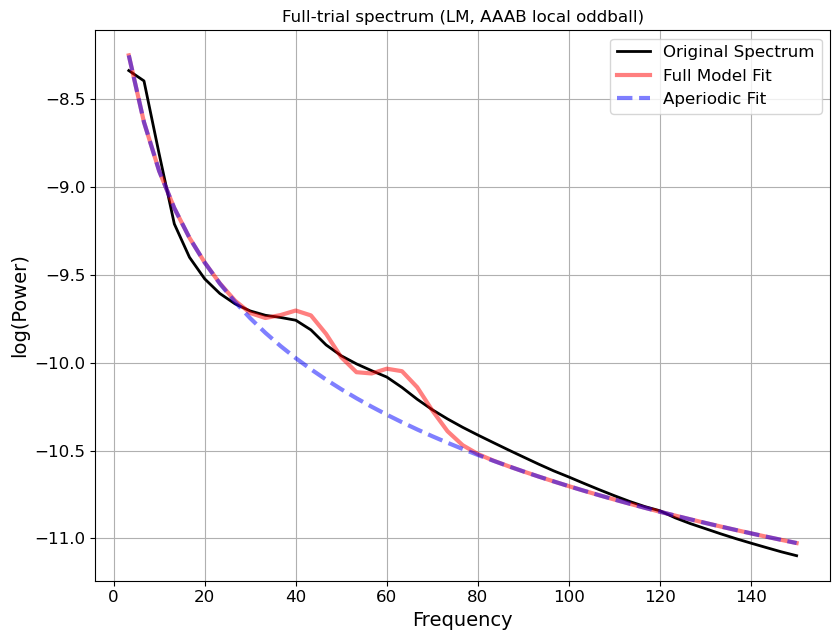

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0357, 4.6202, 1.8311                                      
                                                                                                  
                                       2 peaks were found:                                        
          

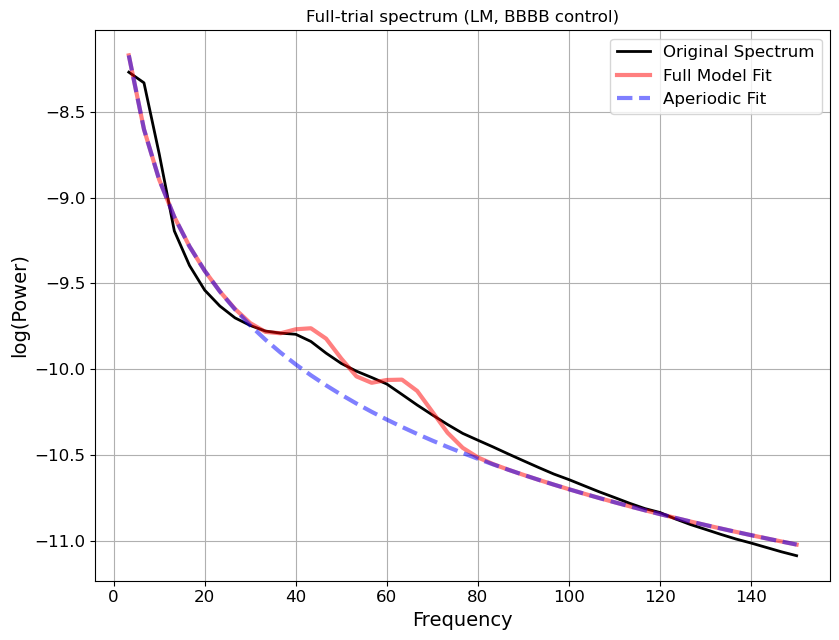

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8277, 18.0651, 1.9847                                     
                                                                                                  
                                       0 peaks were found:                                        
          

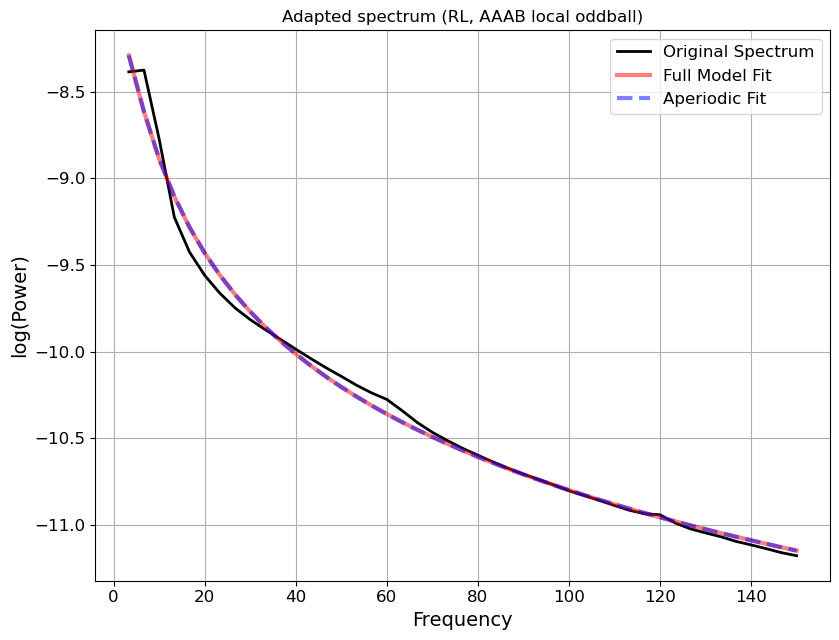

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7534, 16.5671, 2.0165                                     
                                                                                                  
                                       1 peaks were found:                                        
          

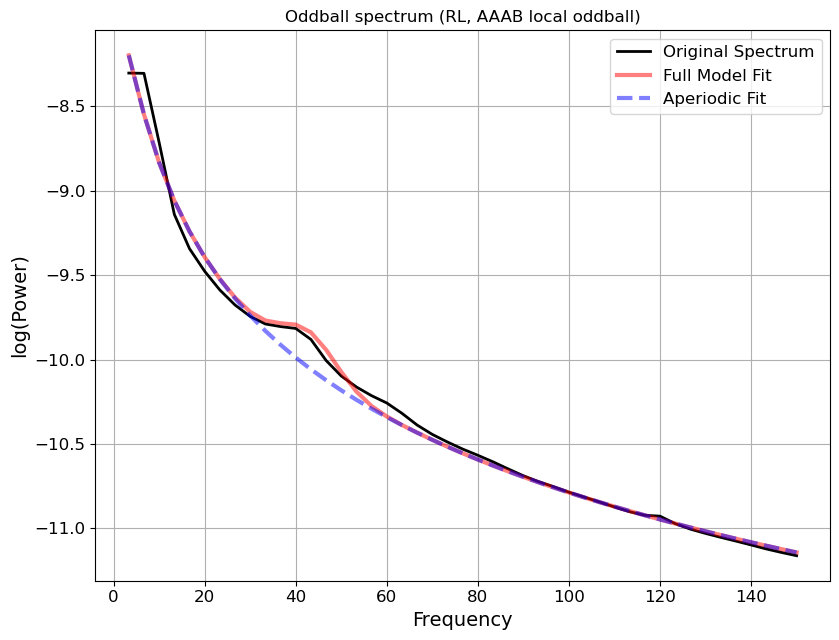

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7757, 11.0937, 1.9979                                     
                                                                                                  
                                       0 peaks were found:                                        
          

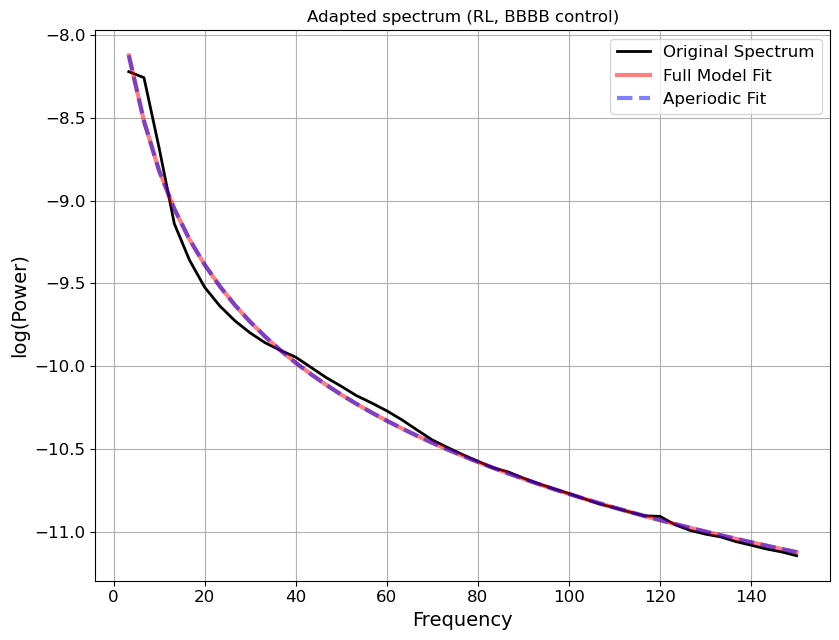

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7871, 11.1314, 1.9918                                     
                                                                                                  
                                       0 peaks were found:                                        
          

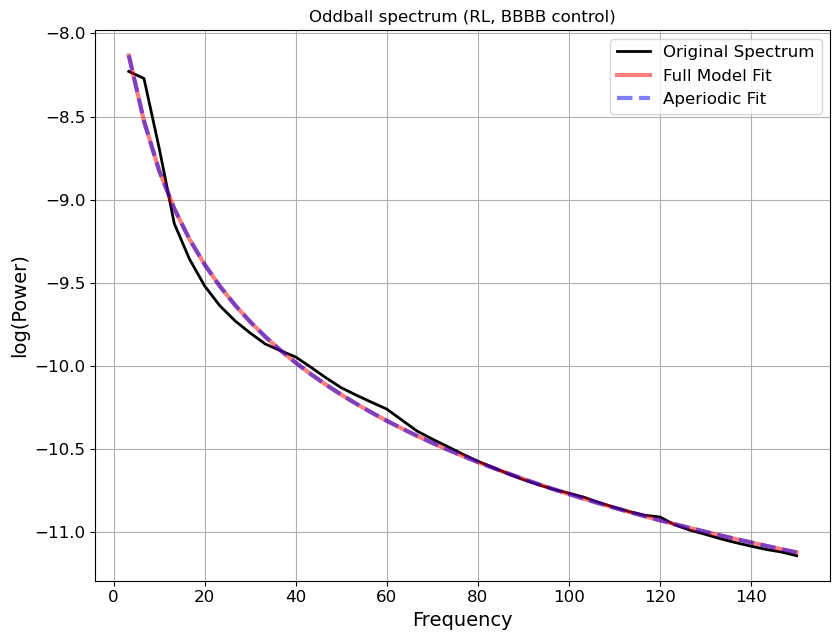

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7613, 21.4505, 2.0192                                     
                                                                                                  
                                       0 peaks were found:                                        
          

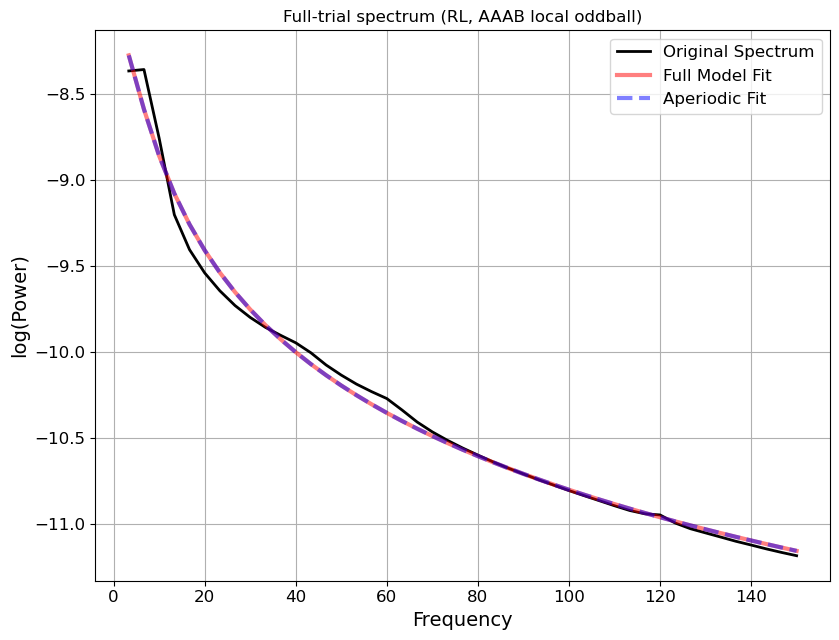

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7620, 12.0795, 2.0067                                     
                                                                                                  
                                       0 peaks were found:                                        
          

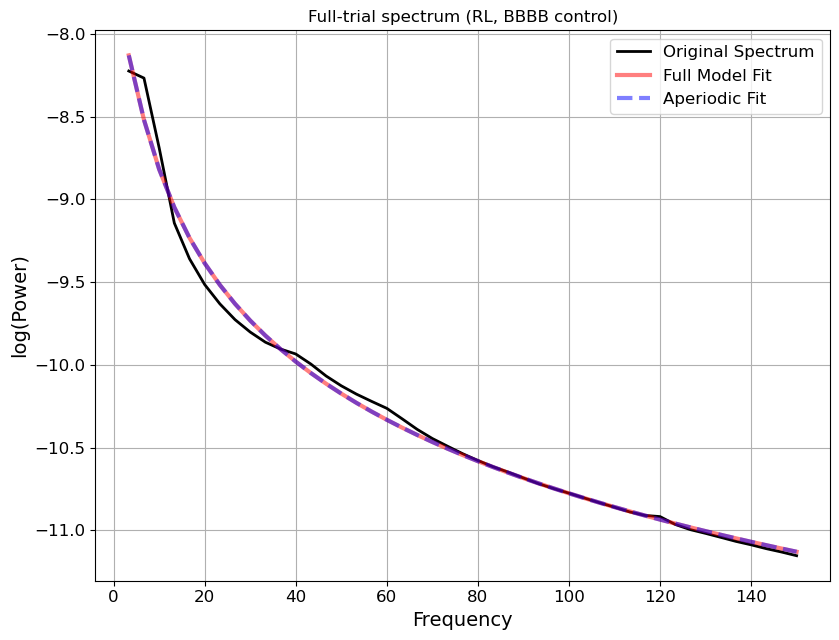

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0839, 14.9019, 1.9096                                     
                                                                                                  
                                       1 peaks were found:                                        
          

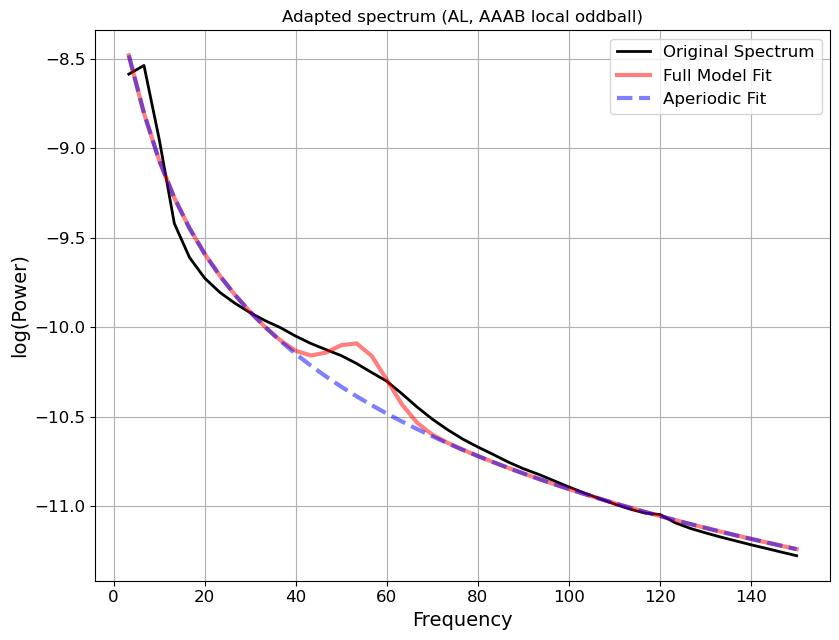

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0623, 13.2438, 1.9171                                     
                                                                                                  
                                       3 peaks were found:                                        
          

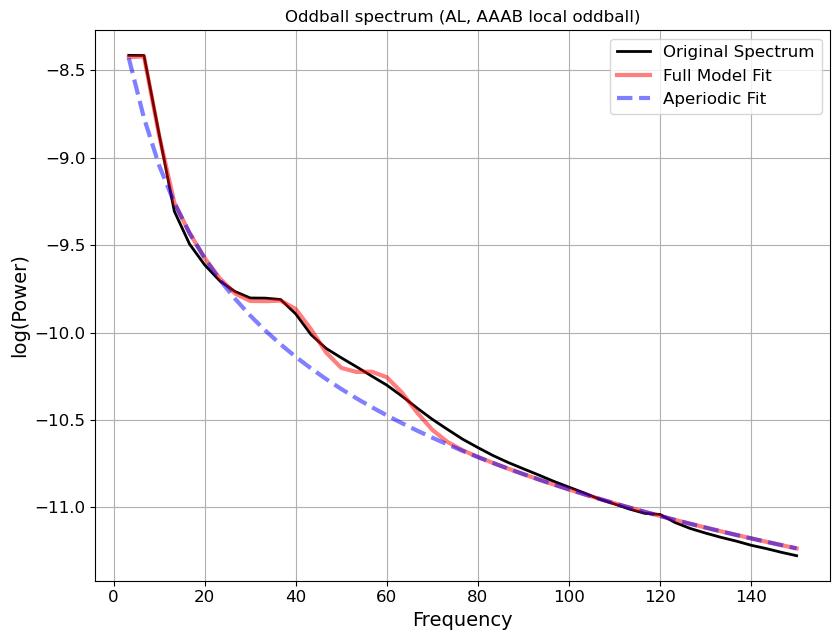

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8032, 17.1589, 2.0291                                     
                                                                                                  
                                       0 peaks were found:                                        
          

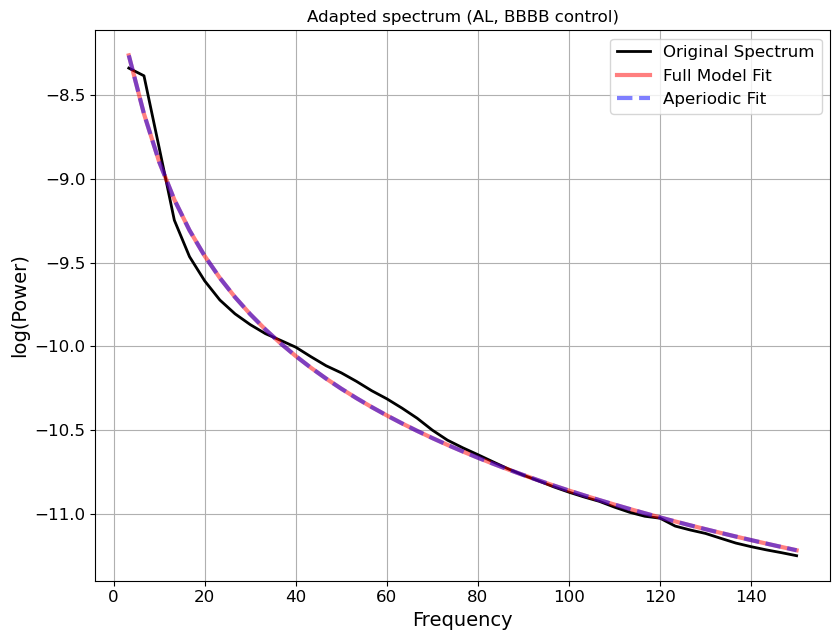

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8403, 16.9202, 2.0099                                     
                                                                                                  
                                       0 peaks were found:                                        
          

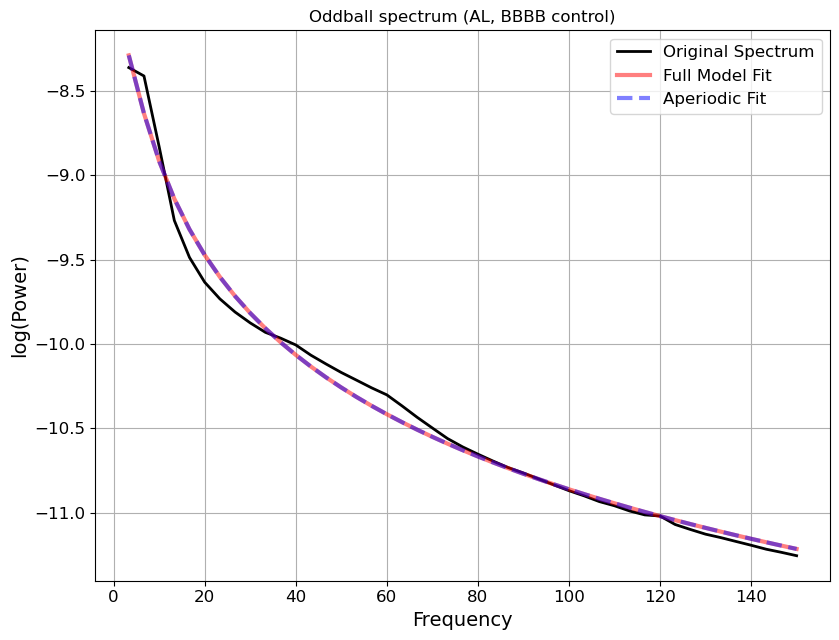

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8722, 28.7728, 2.0067                                     
                                                                                                  
                                       0 peaks were found:                                        
          

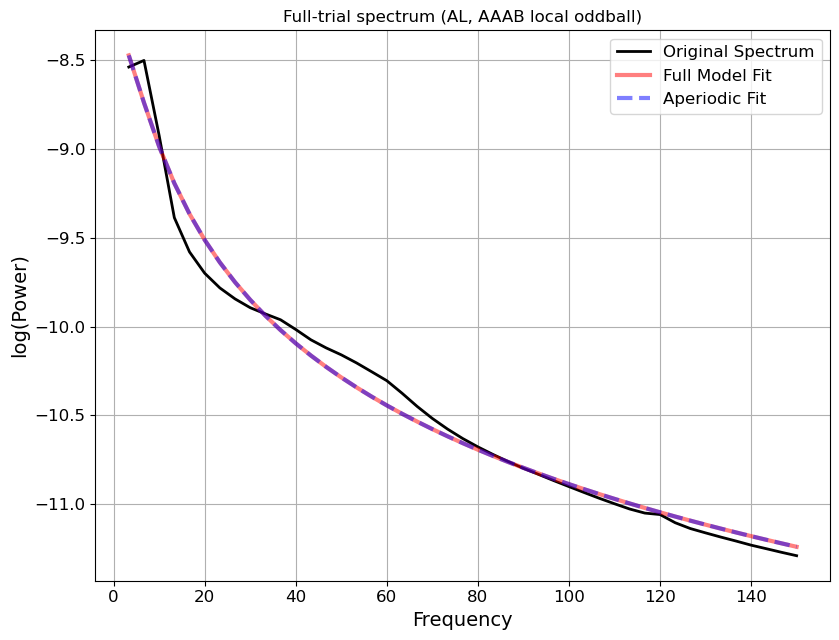

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8188, 19.1846, 2.0234                                     
                                                                                                  
                                       0 peaks were found:                                        
          

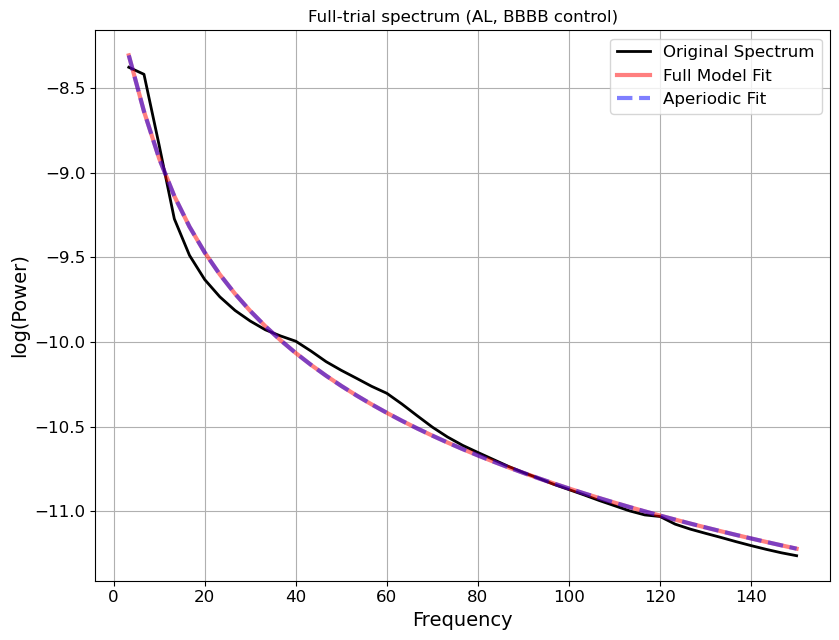

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0639, 20.3314, 1.9237                                     
                                                                                                  
                                       1 peaks were found:                                        
          

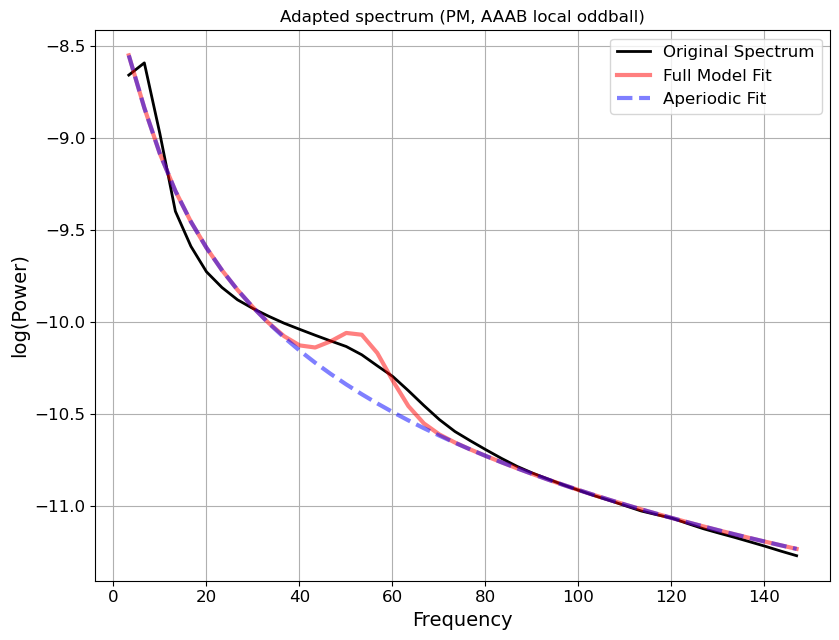

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0314, 13.2358, 1.9383                                     
                                                                                                  
                                       2 peaks were found:                                        
          

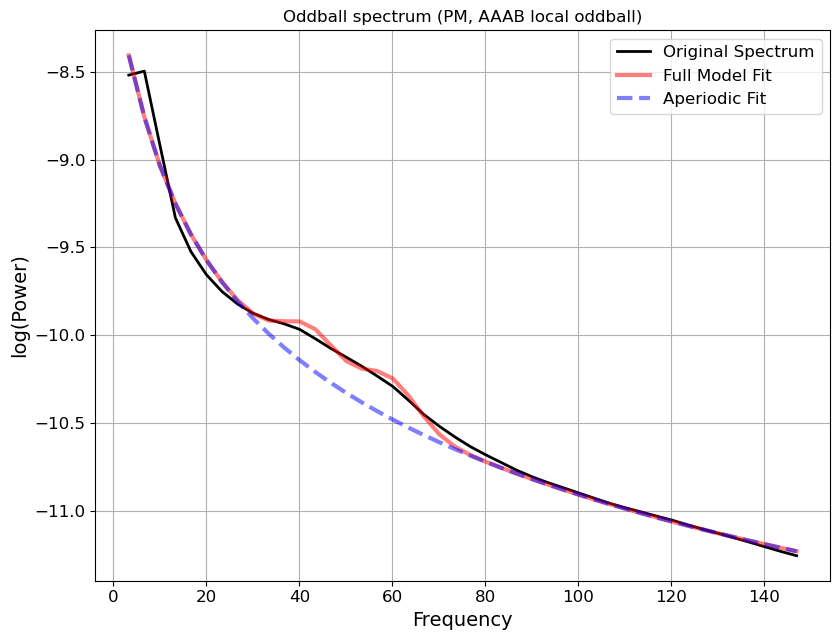

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9308, 14.5074, 2.0050                                     
                                                                                                  
                                       2 peaks were found:                                        
          

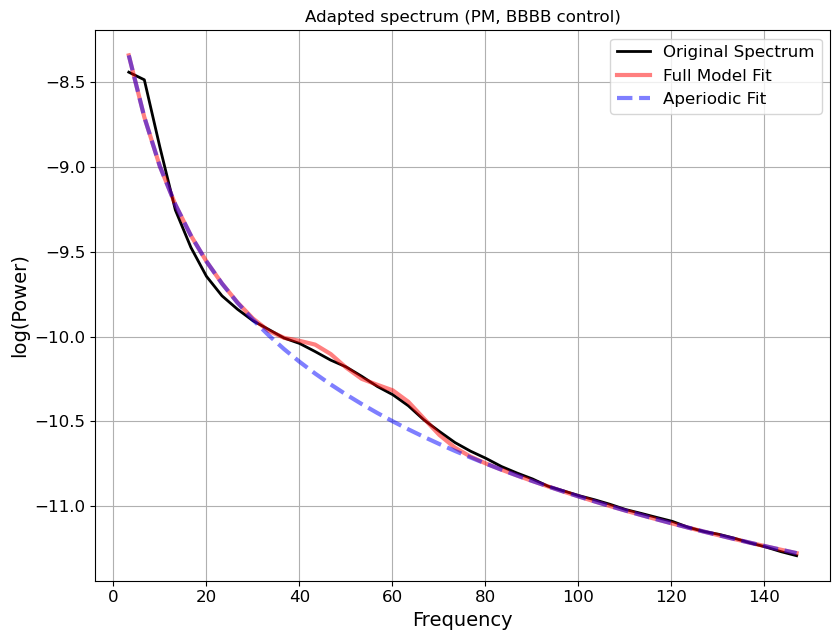

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9152, 17.2337, 2.0085                                     
                                                                                                  
                                       1 peaks were found:                                        
          

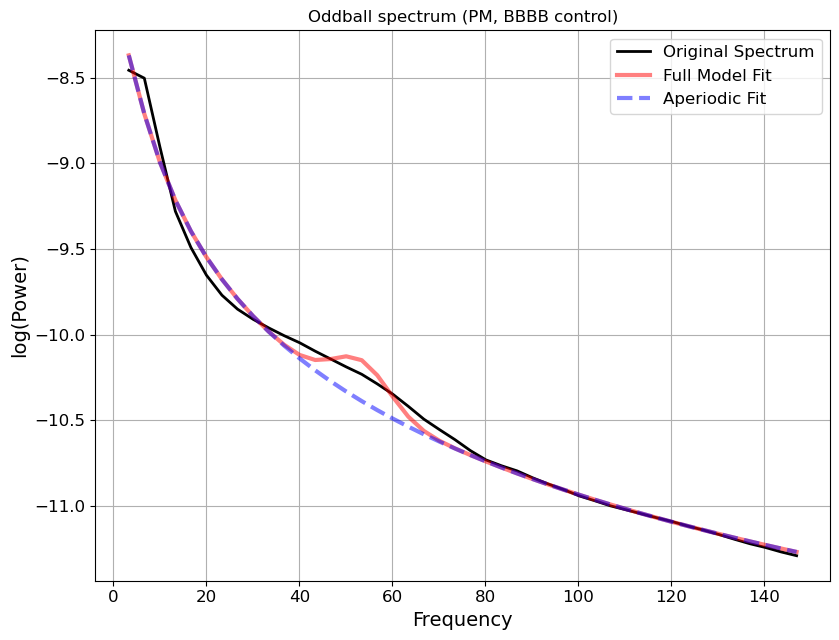

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0213, 20.9453, 1.9456                                     
                                                                                                  
                                       1 peaks were found:                                        
          

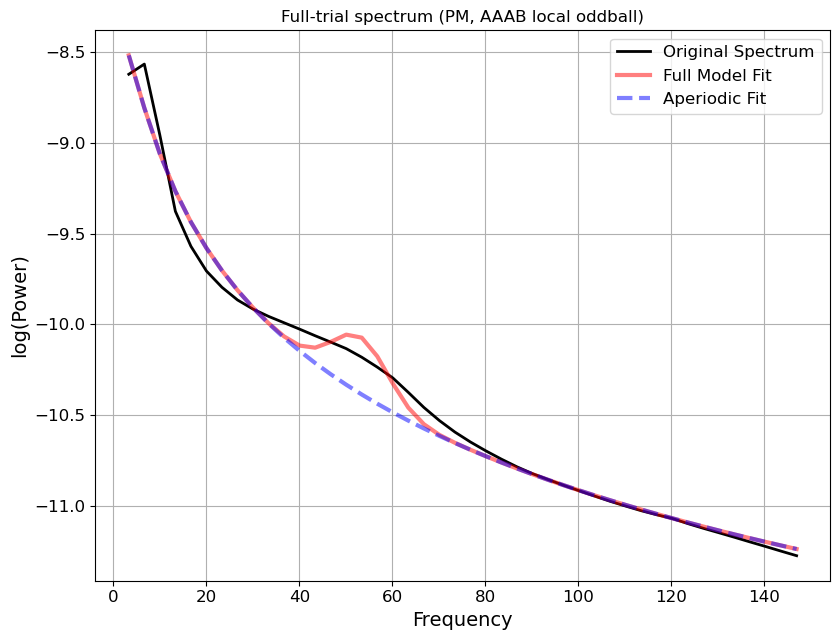

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9016, 18.3378, 2.0154                                     
                                                                                                  
                                       1 peaks were found:                                        
          

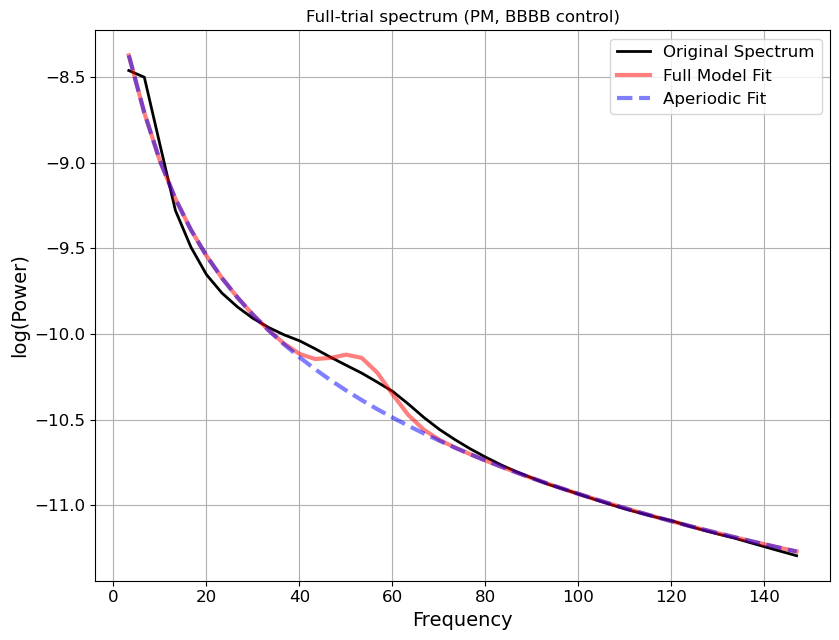

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8198, 28.1576, 2.0048                                     
                                                                                                  
                                       1 peaks were found:                                        
          

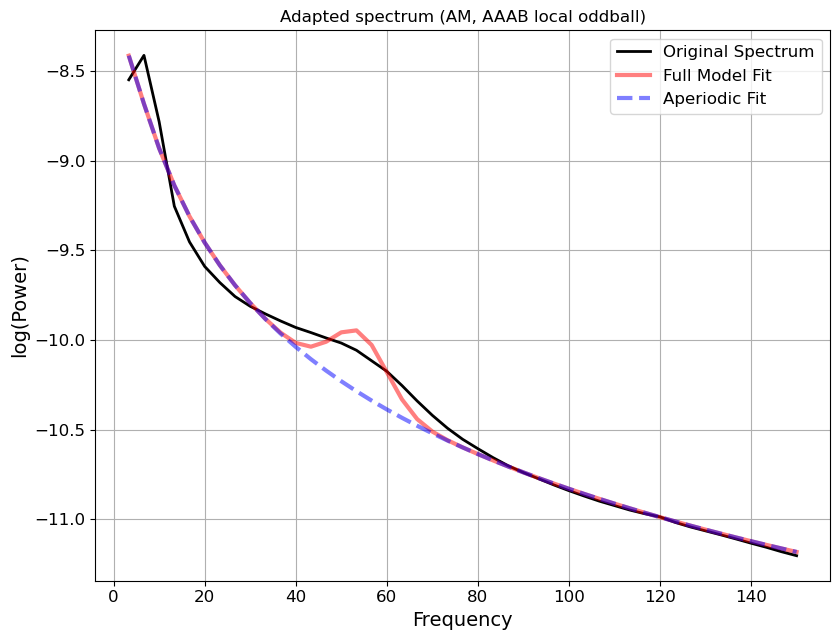

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7997, 21.9442, 2.0163                                     
                                                                                                  
                                       2 peaks were found:                                        
          

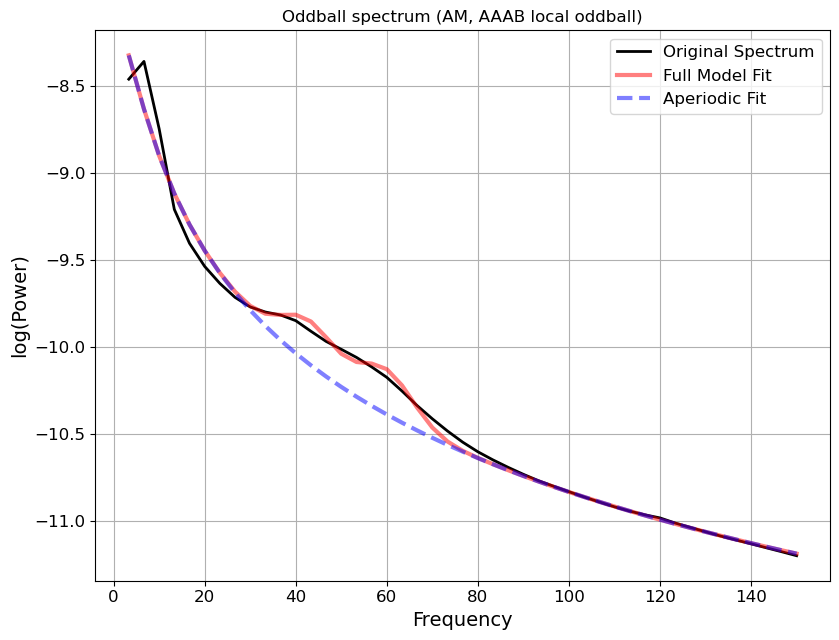

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.6899, 23.6175, 2.0765                                     
                                                                                                  
                                       1 peaks were found:                                        
          

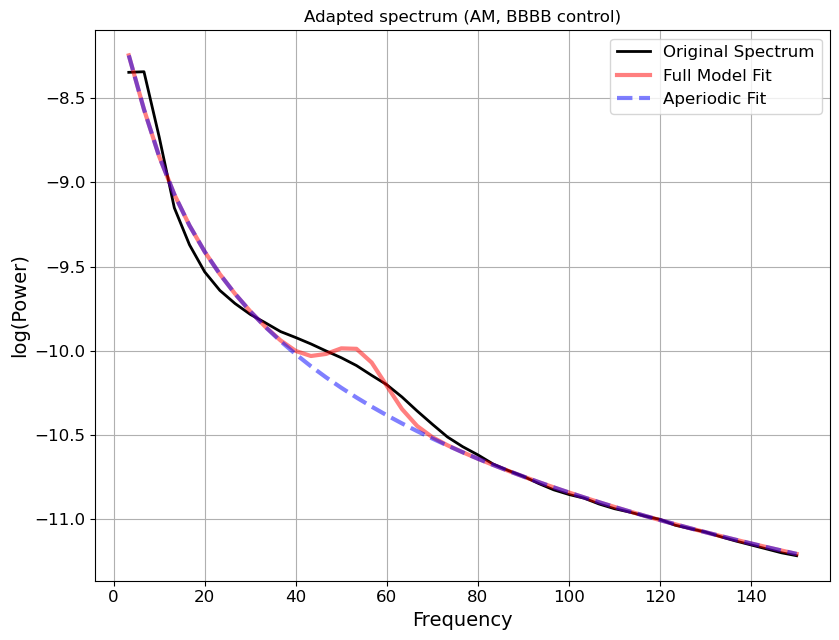

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7689, 19.2950, 2.0416                                     
                                                                                                  
                                       2 peaks were found:                                        
          

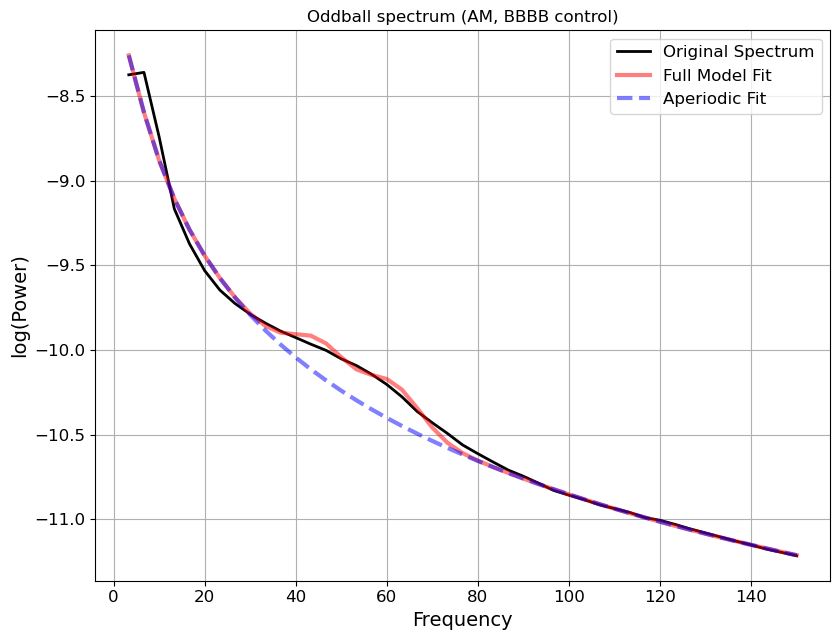

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISam


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7768, 30.0352, 2.0295                                     
                                                                                                  
                                       1 peaks were found:                                        
          

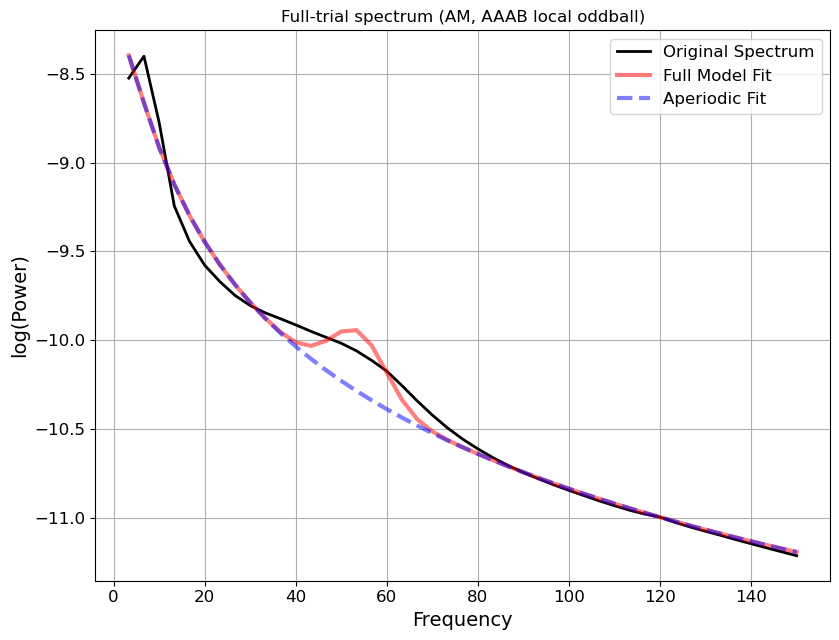

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.6909, 25.2115, 2.0769                                     
                                                                                                  
                                       1 peaks were found:                                        
          

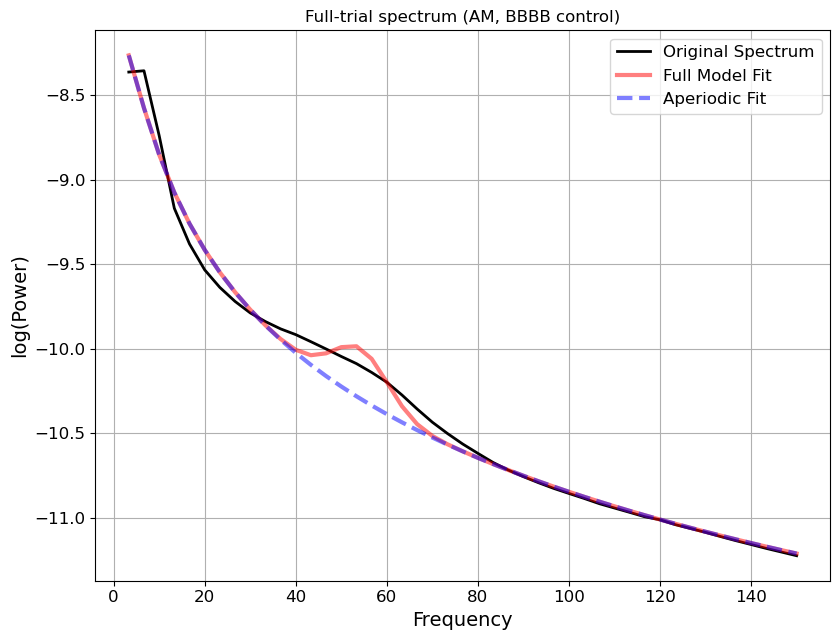

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISam
INFO:root:Applied FOOOF analysis to evoked power spectra for ssa


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2429, 6.5707, 1.7552                                      
                                                                                                  
                                       4 peaks were found:                                        
          

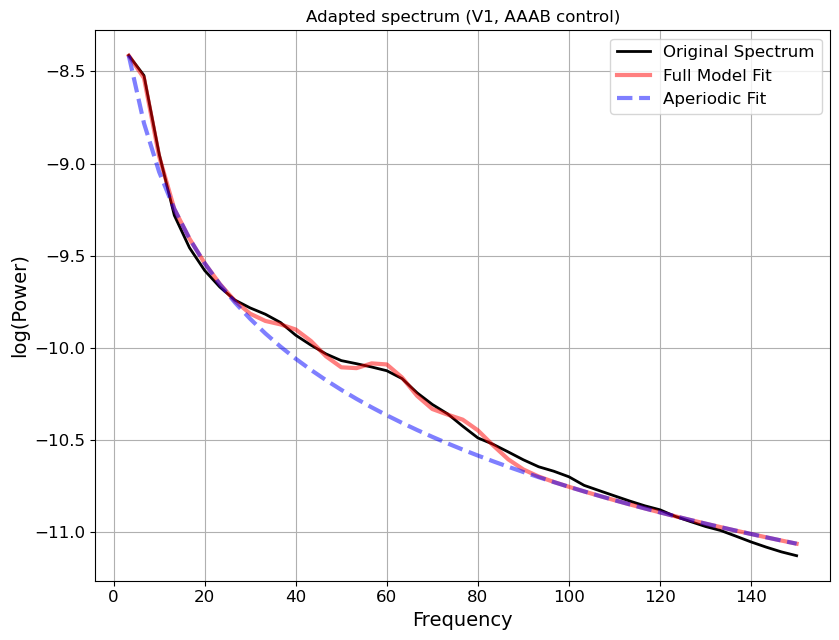

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8287, 12.8441, 1.9547                                     
                                                                                                  
                                       3 peaks were found:                                        
          

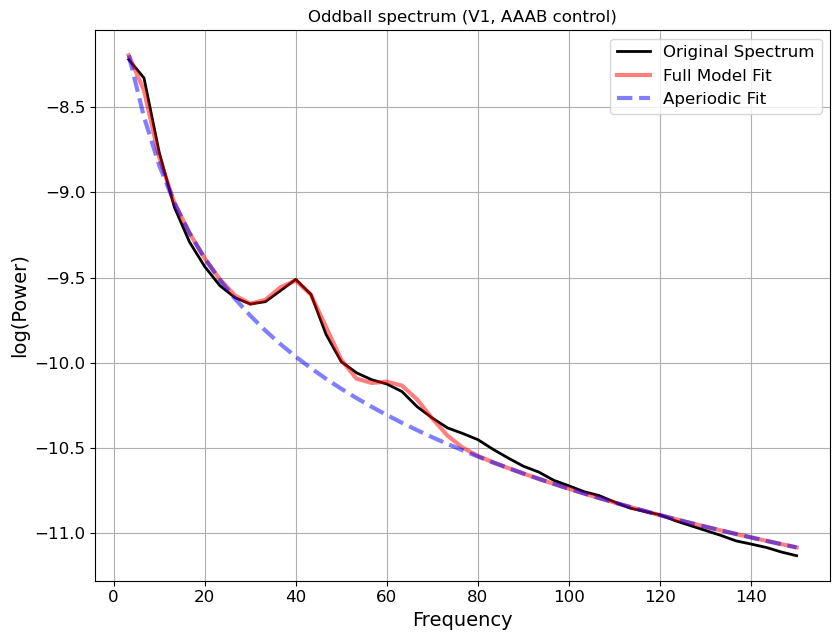

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8614, 58.7309, 1.9937                                     
                                                                                                  
                                       3 peaks were found:                                        
          

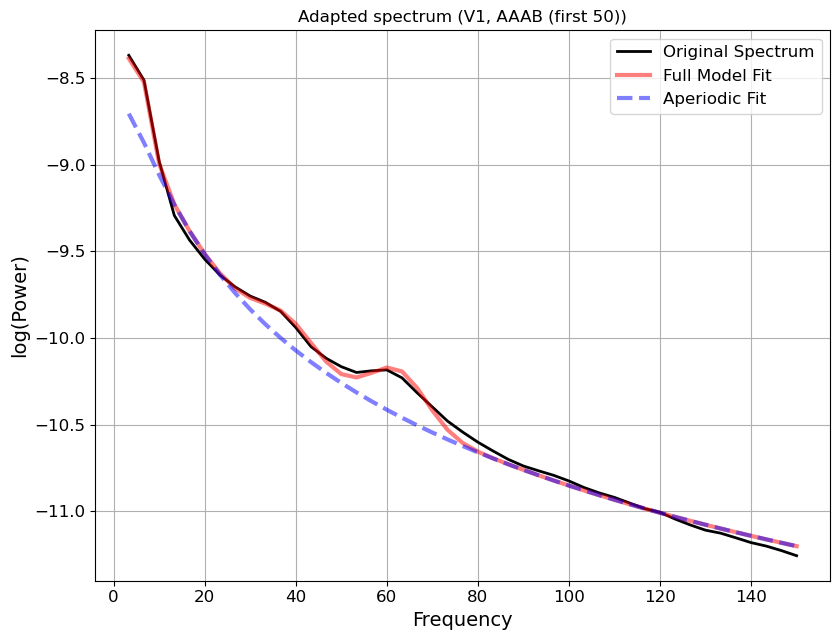

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.6573, 65.1214, 2.0645                                     
                                                                                                  
                                       3 peaks were found:                                        
          

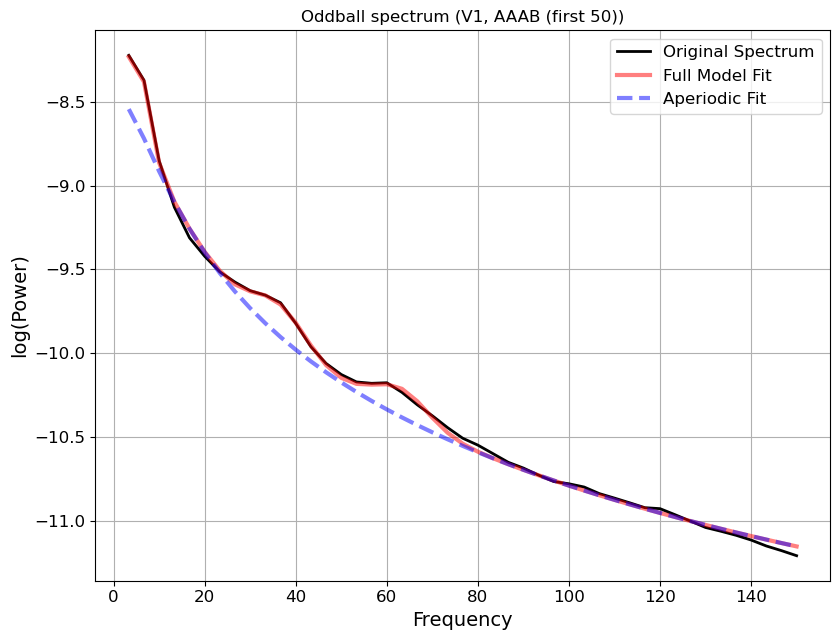

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1456, 8.8806, 1.8060                                      
                                                                                                  
                                       4 peaks were found:                                        
          

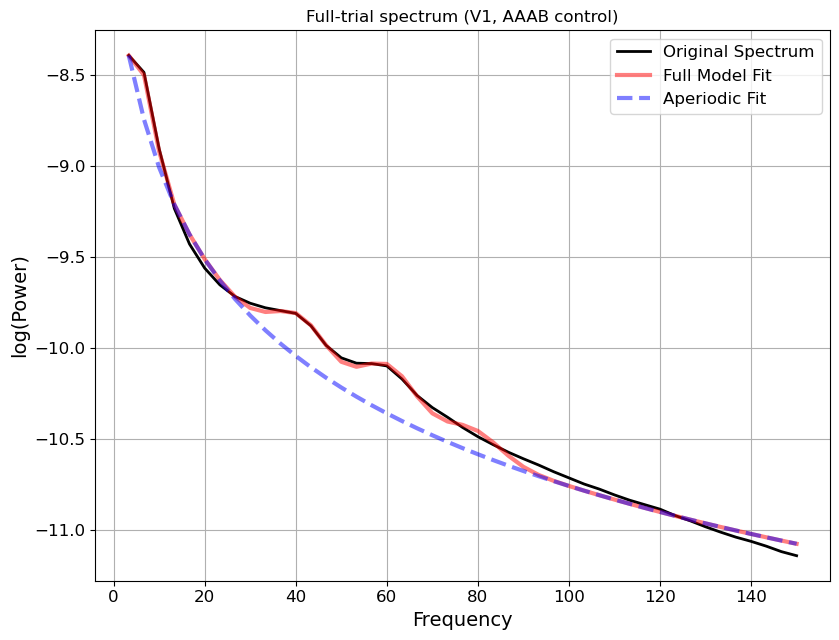

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9215, 28.9238, 1.9634                                     
                                                                                                  
                                       4 peaks were found:                                        
          

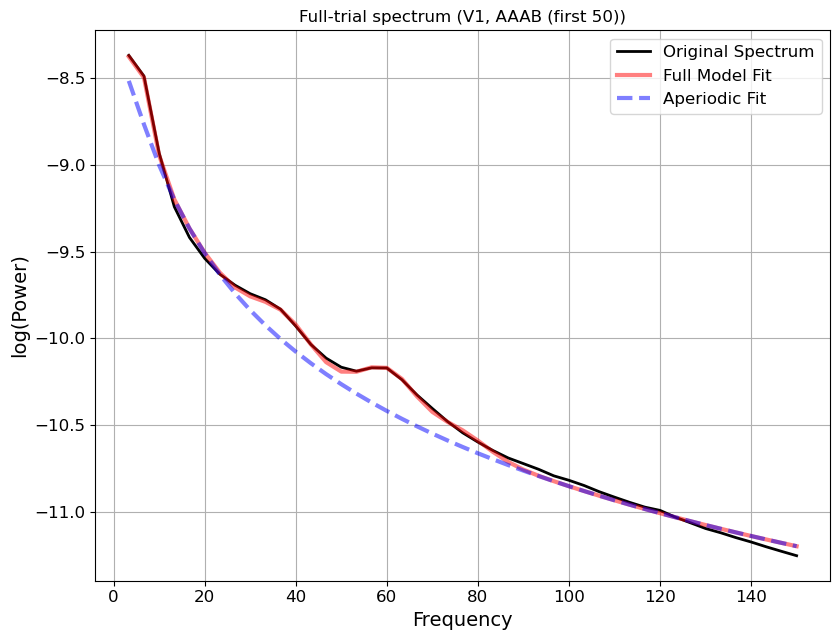

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISp


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0622, 14.2896, 1.7981                                     
                                                                                                  
                                       1 peaks were found:                                        
          

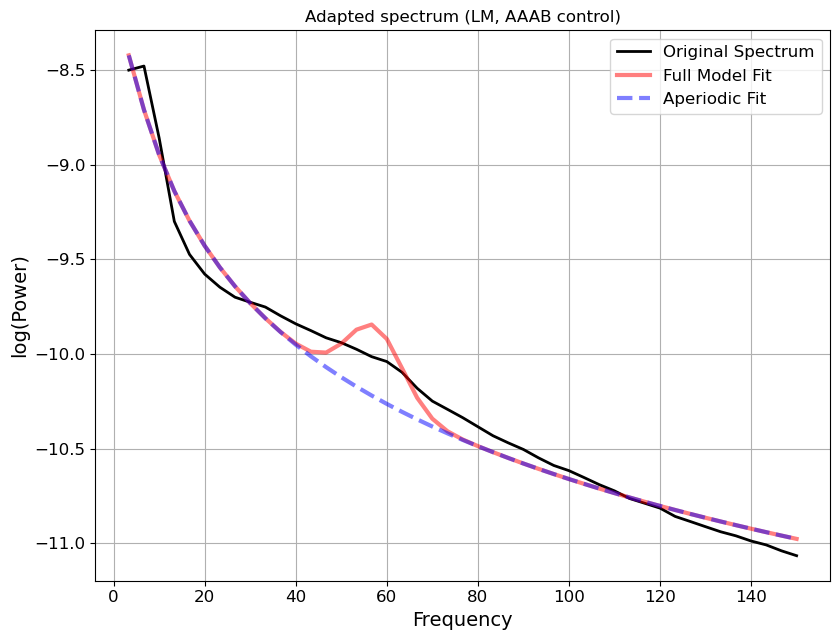

/home/eli/miniforge3/envs/ephys/lib/python3.12/site-packages/fooof/core/funcs.py:62: RuntimeWarning: invalid value encountered in log10
  ys = offset - np.log10(knee + xs**exp)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.5128, 61.6153, 2.0390                                     
                                                                                                  
                                       0 peaks were found:                                        
          

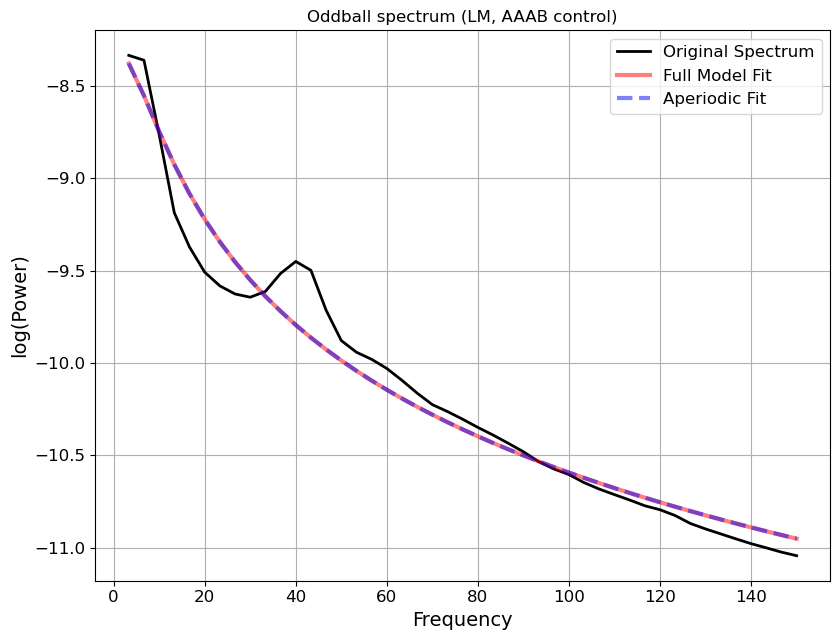

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0341, 9.6096, 1.8684                                      
                                                                                                  
                                       4 peaks were found:                                        
          

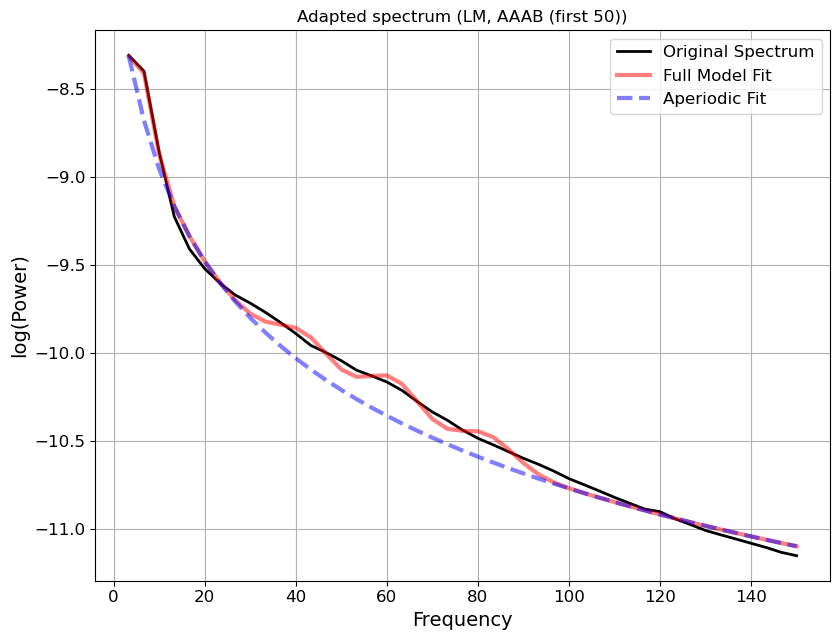

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8214, 27.7748, 1.9602                                     
                                                                                                  
                                       5 peaks were found:                                        
          

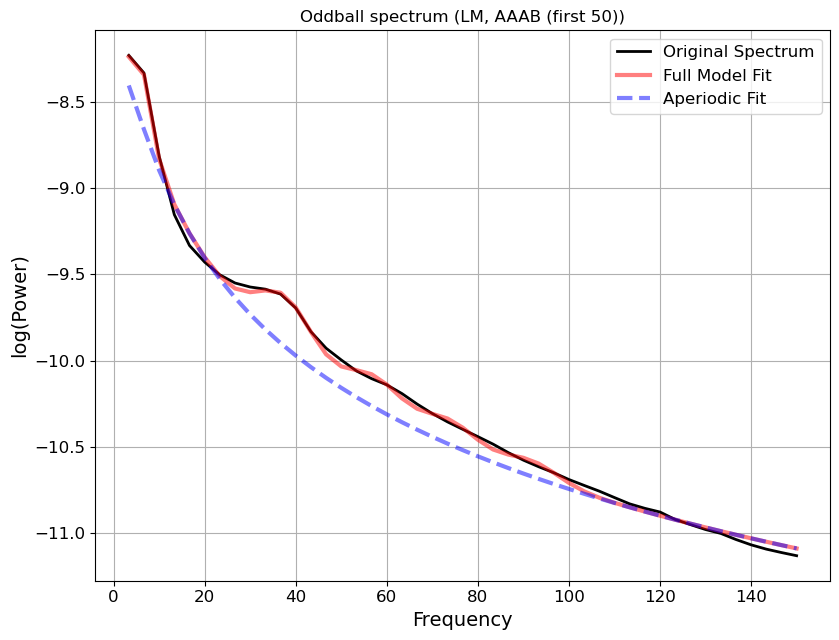

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.1248, 9.2181, 1.7781                                      
                                                                                                  
                                       2 peaks were found:                                        
          

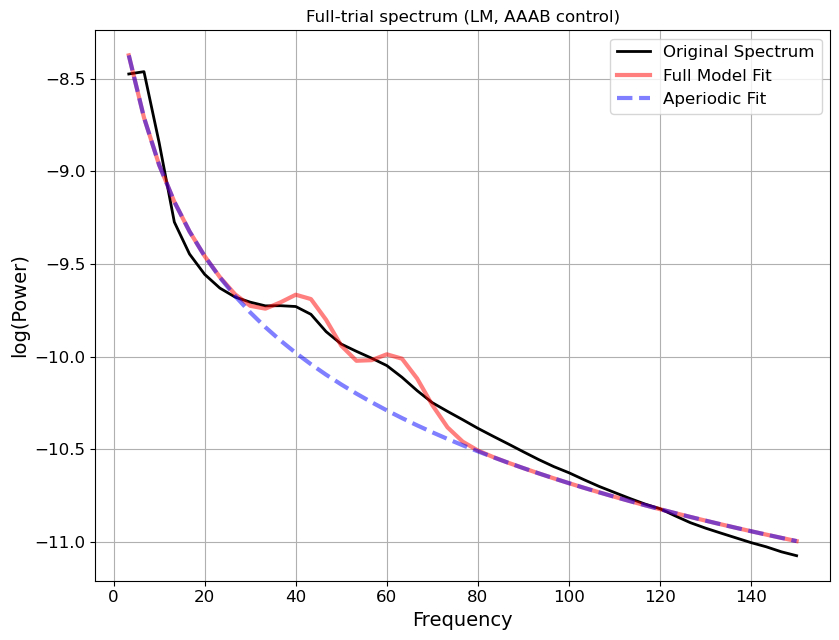

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0301, 10.8002, 1.8713                                     
                                                                                                  
                                       4 peaks were found:                                        
          

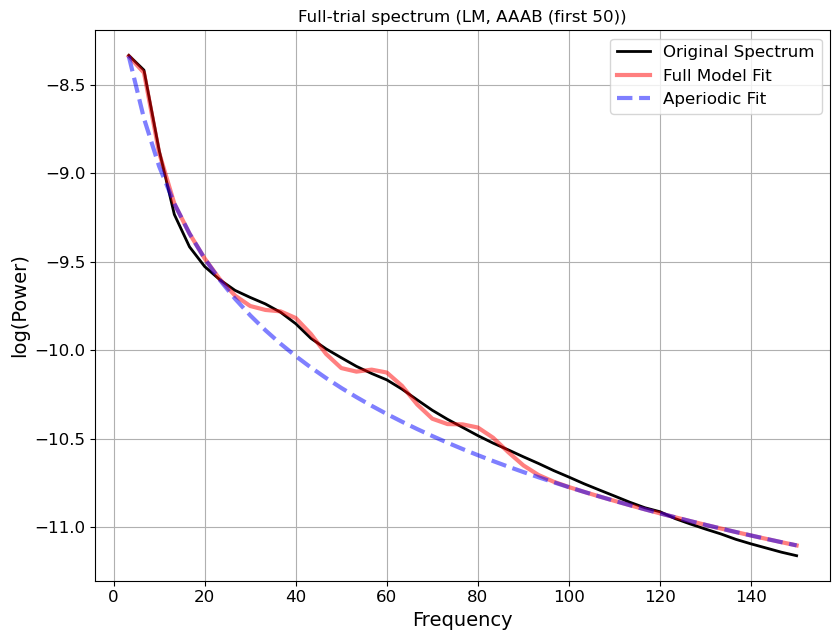

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8348, 23.6066, 1.9667                                     
                                                                                                  
                                       0 peaks were found:                                        
          

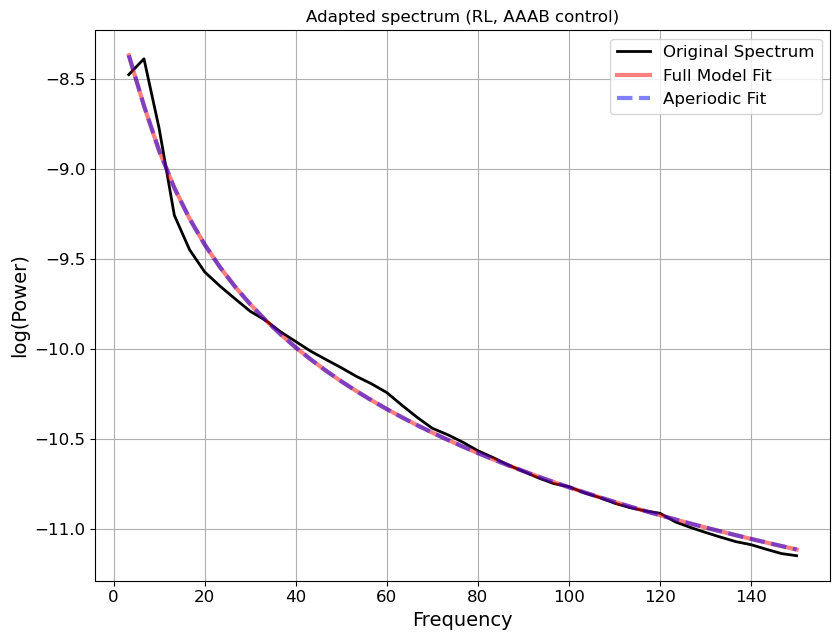

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8245, 17.1902, 1.9705                                     
                                                                                                  
                                       1 peaks were found:                                        
          

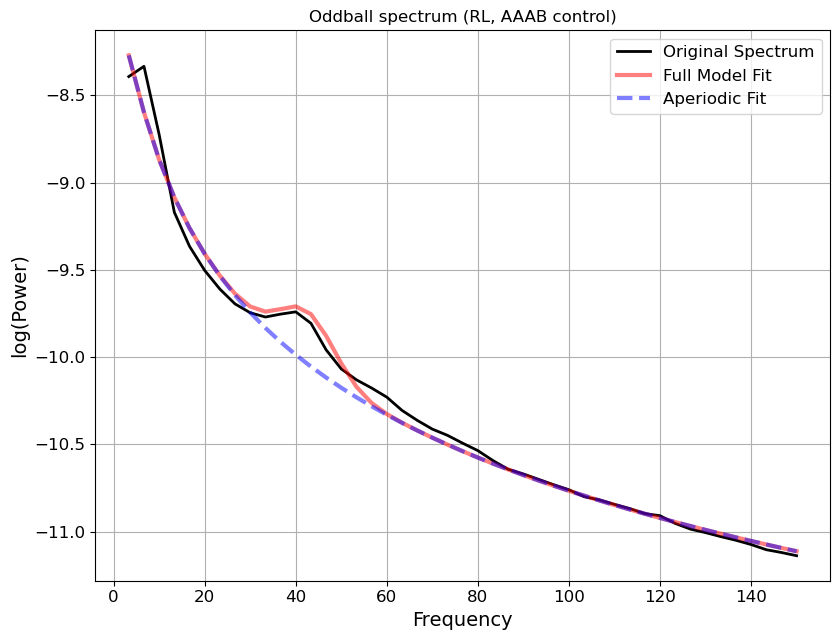

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8121, 22.2082, 2.0223                                     
                                                                                                  
                                       0 peaks were found:                                        
          

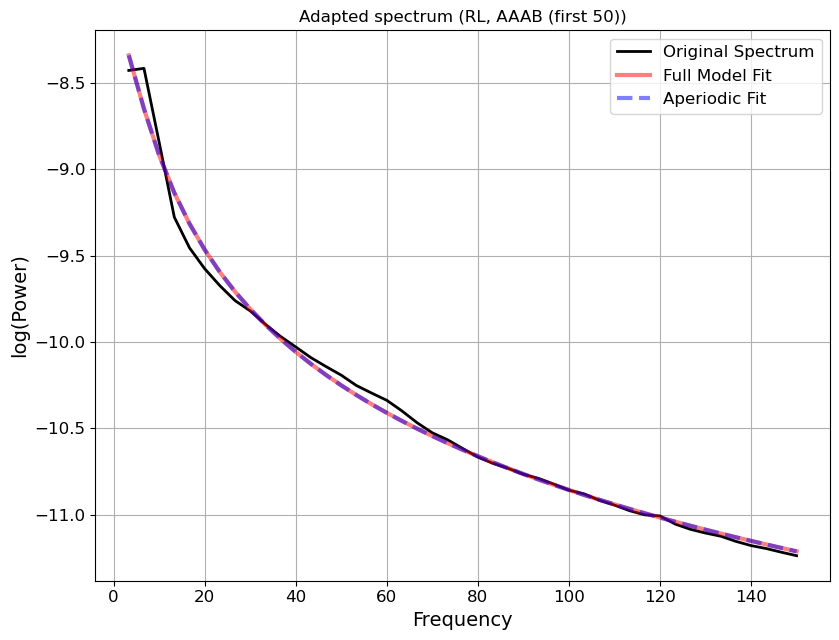

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9467, 19.1108, 1.9504                                     
                                                                                                  
                                       3 peaks were found:                                        
          

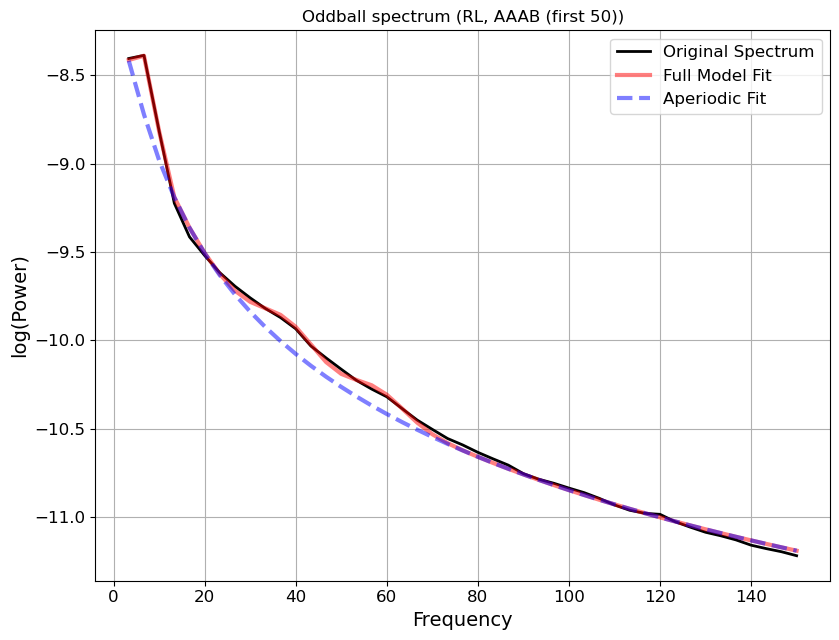

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7743, 26.8619, 1.9978                                     
                                                                                                  
                                       0 peaks were found:                                        
          

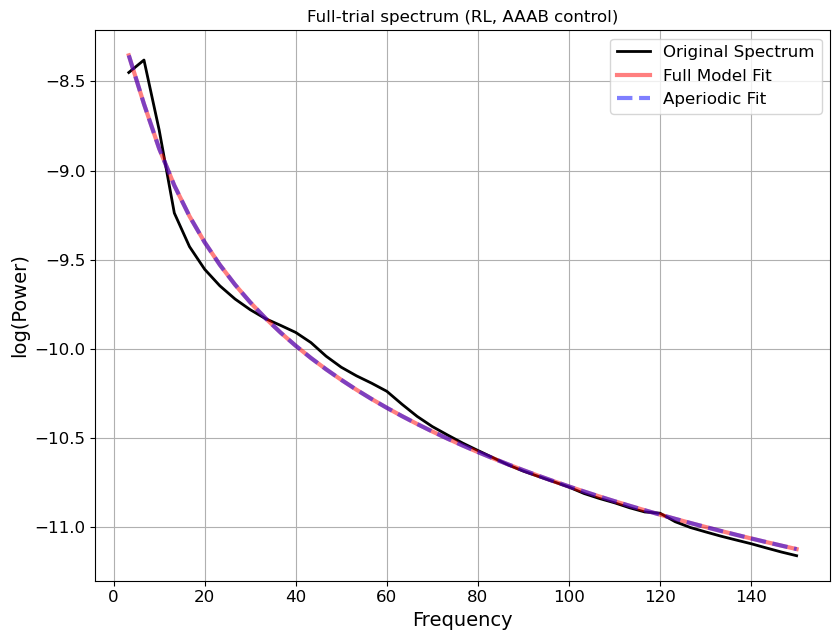

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7915, 25.8114, 2.0342                                     
                                                                                                  
                                       0 peaks were found:                                        
          

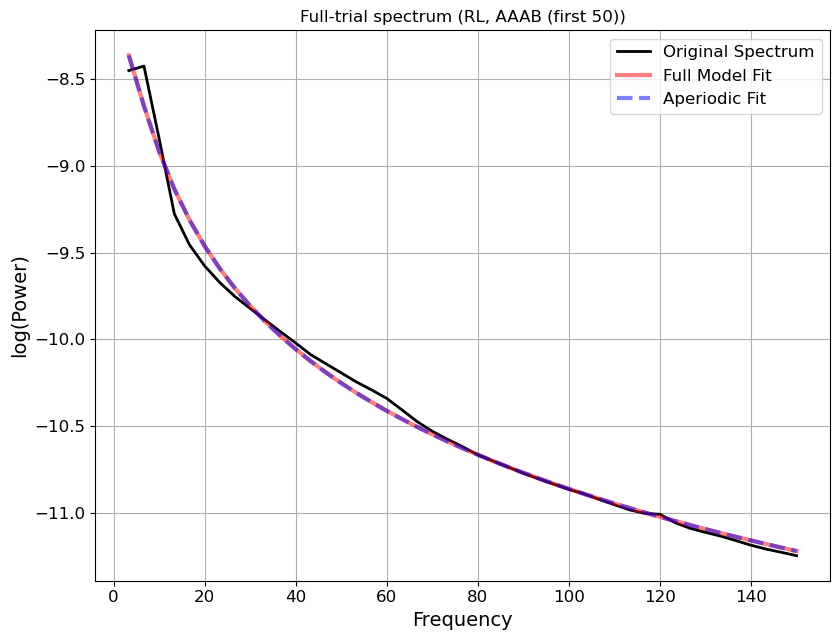

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISrl


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9827, 17.5154, 1.9593                                     
                                                                                                  
                                       1 peaks were found:                                        
          

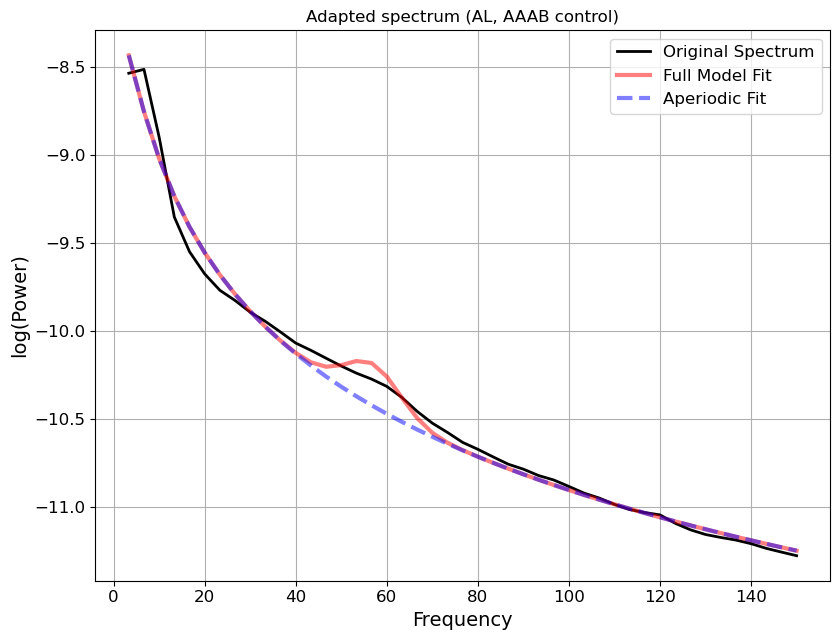

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9275, 12.2568, 1.9890                                     
                                                                                                  
                                       2 peaks were found:                                        
          

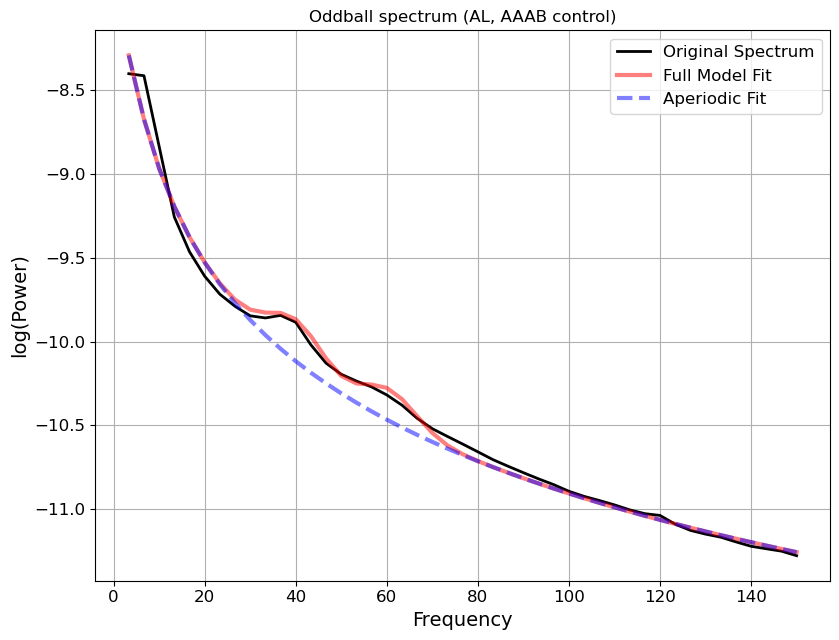

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2071, 15.0513, 1.8726                                     
                                                                                                  
                                       3 peaks were found:                                        
          

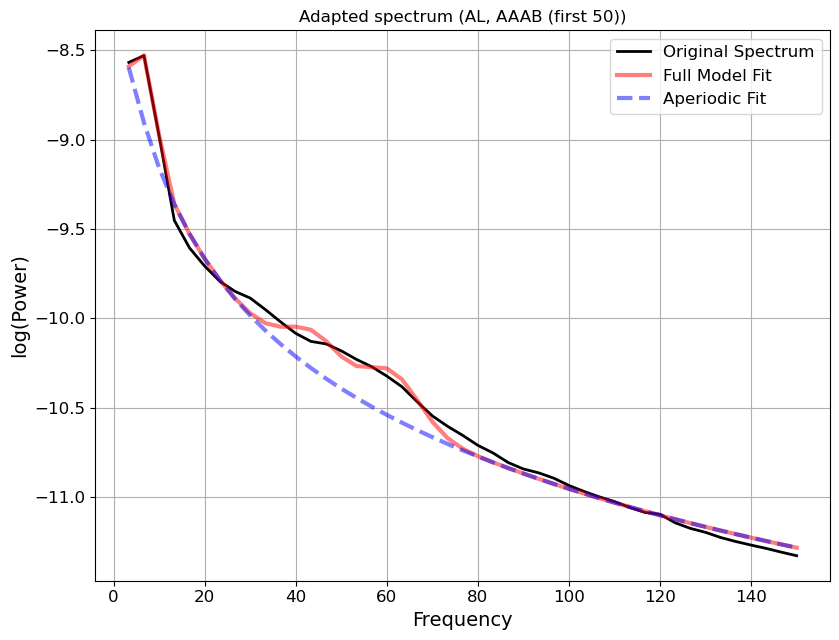

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0173, 14.9023, 1.9623                                     
                                                                                                  
                                       4 peaks were found:                                        
          

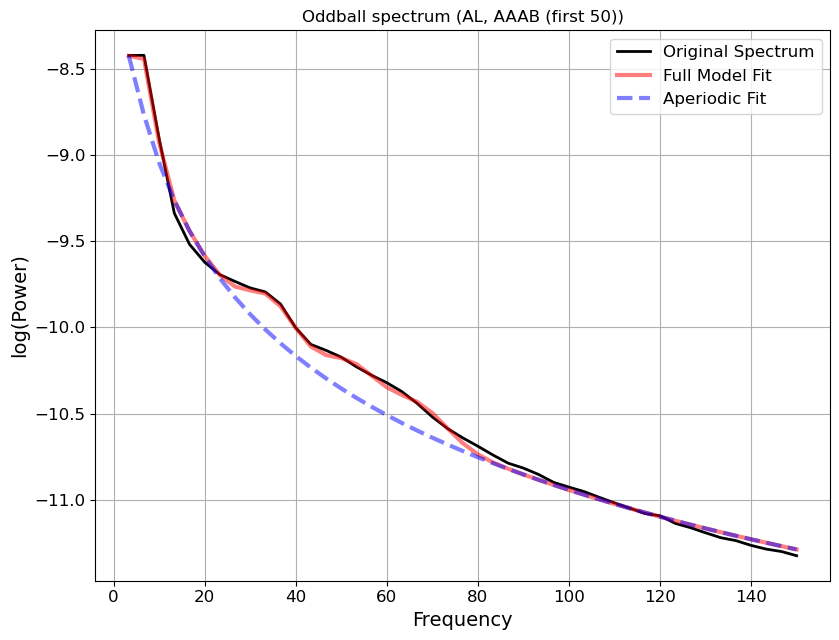

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8440, 27.5825, 2.0205                                     
                                                                                                  
                                       0 peaks were found:                                        
          

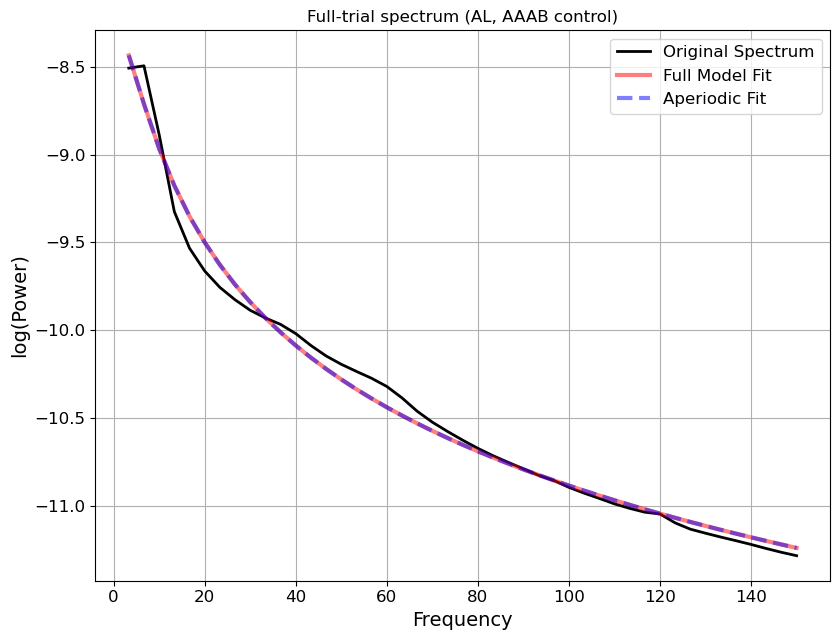

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2059, 12.1429, 1.8851                                     
                                                                                                  
                                       5 peaks were found:                                        
          

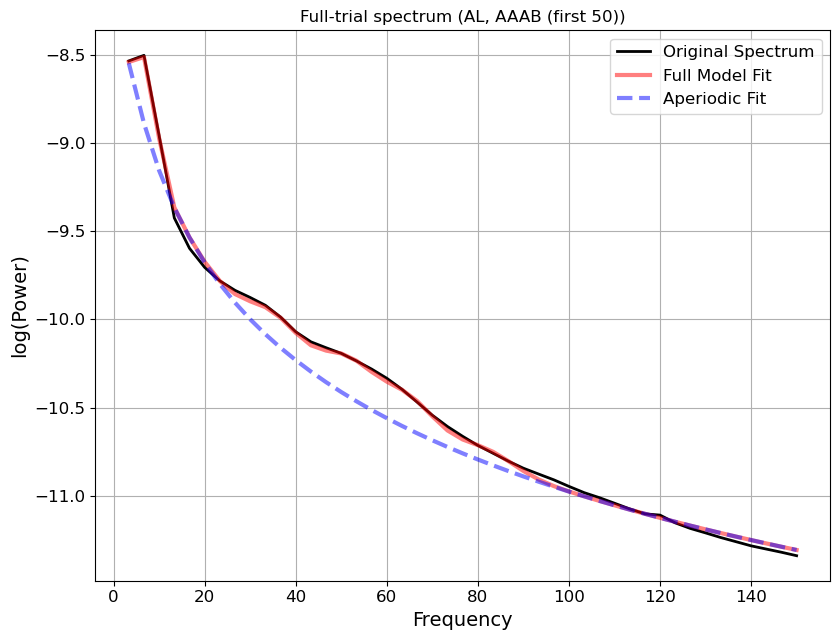

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISal


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0276, 28.2329, 1.9364                                     
                                                                                                  
                                       1 peaks were found:                                        
          

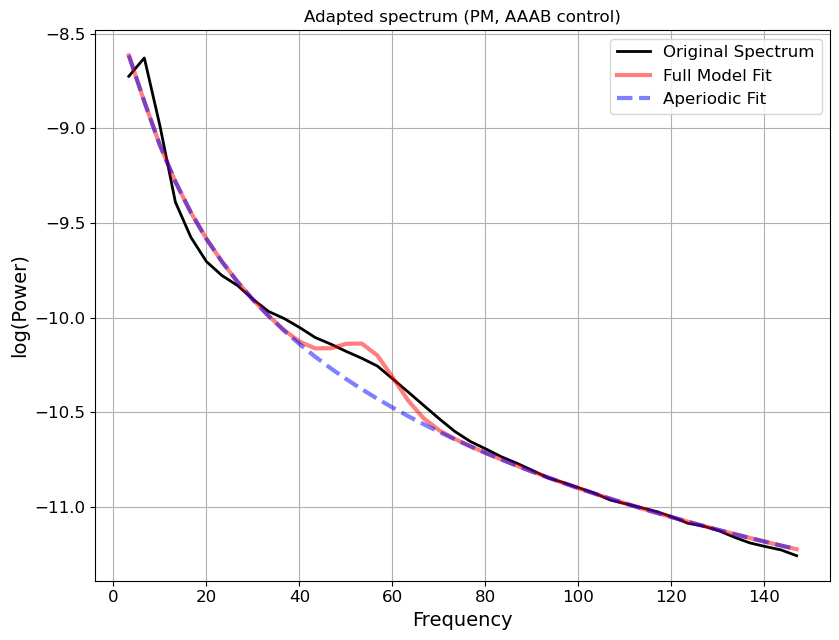

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0510, 17.3108, 1.9278                                     
                                                                                                  
                                       2 peaks were found:                                        
          

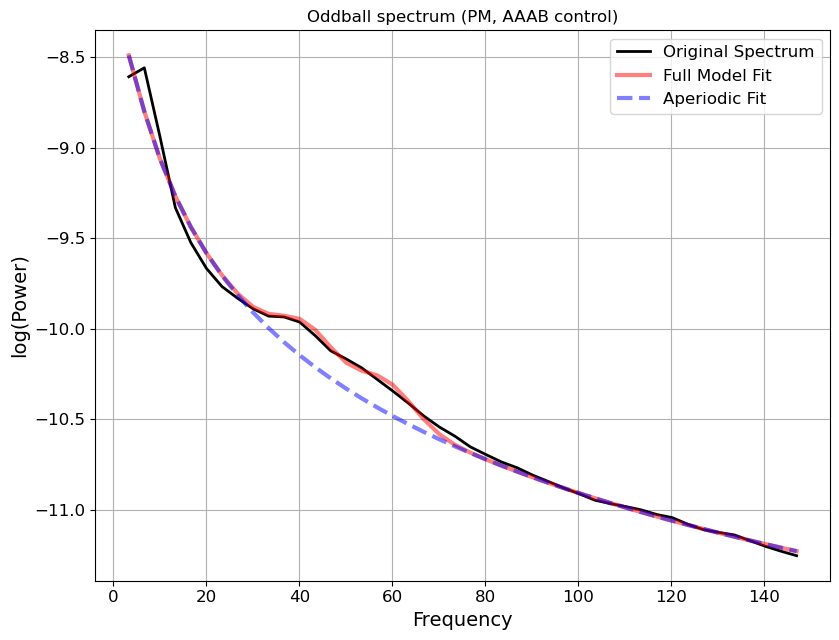

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0489, 22.7535, 1.9445                                     
                                                                                                  
                                       1 peaks were found:                                        
          

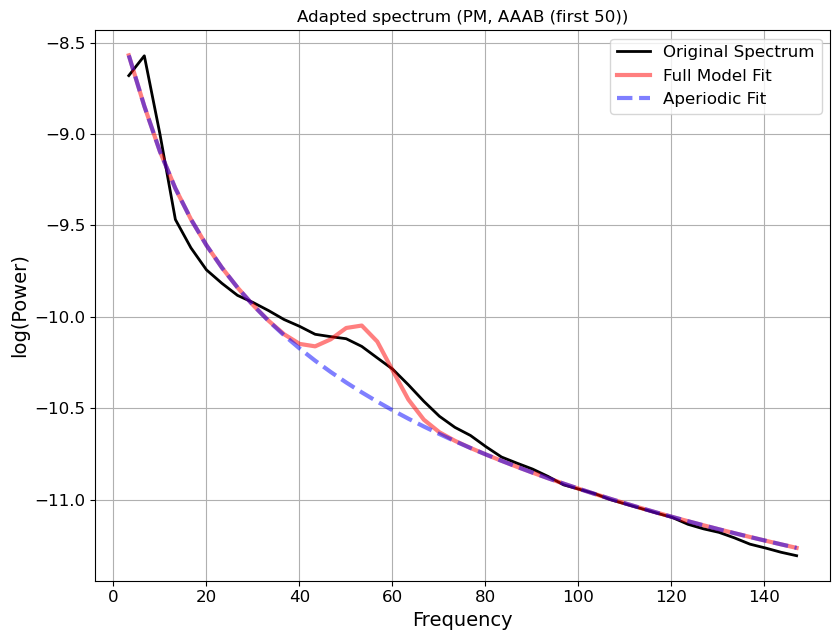

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.2602, 13.8077, 1.8350                                     
                                                                                                  
                                       4 peaks were found:                                        
          

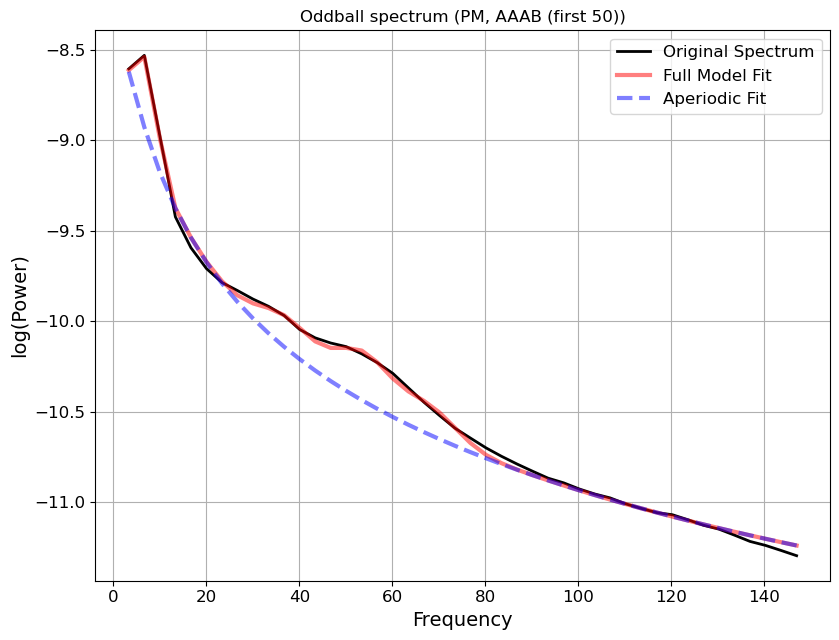

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0128, 26.9842, 1.9449                                     
                                                                                                  
                                       1 peaks were found:                                        
          

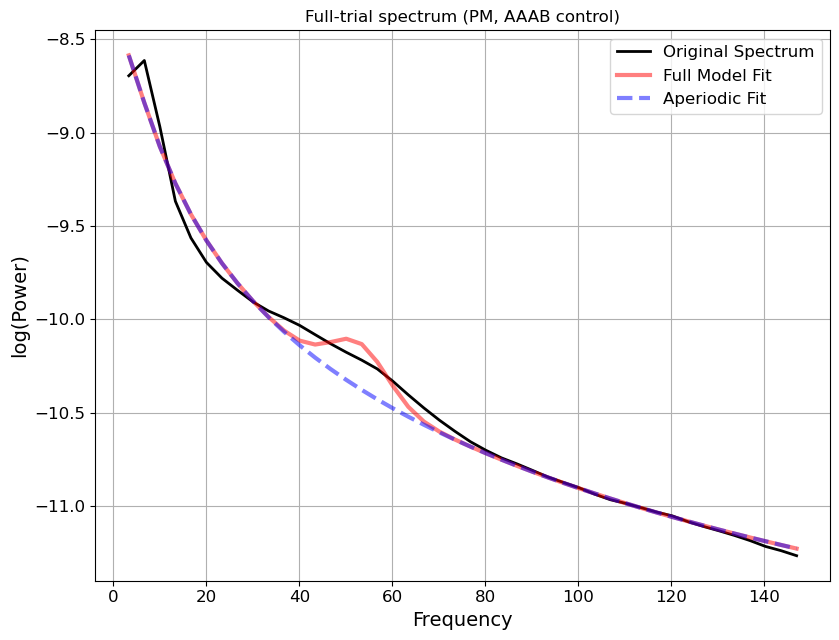

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 147 Hz                        
                                 Frequency Resolution is 3.34 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.0467, 23.1566, 1.9463                                     
                                                                                                  
                                       1 peaks were found:                                        
          

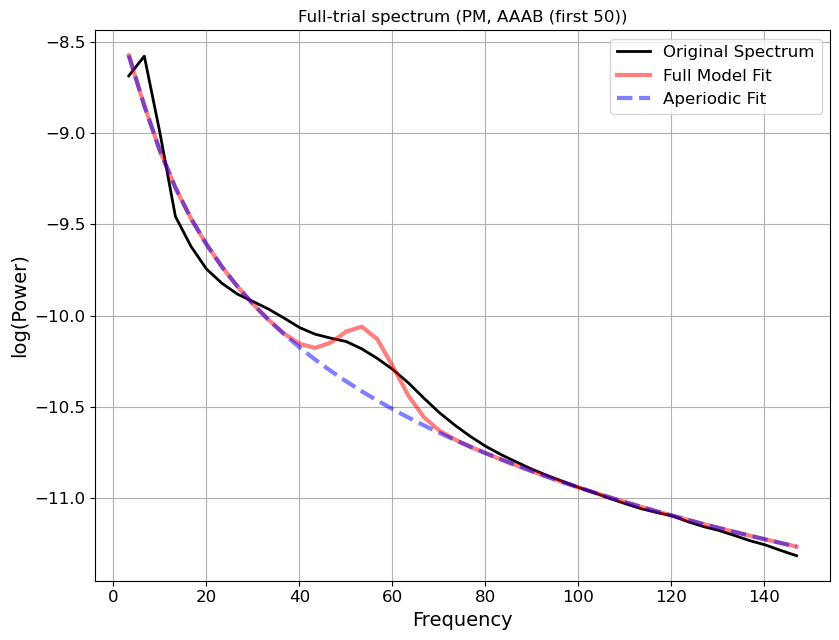

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISpm


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.9002, 12.7543, 1.9681                                     
                                                                                                  
                                       2 peaks were found:                                        
          

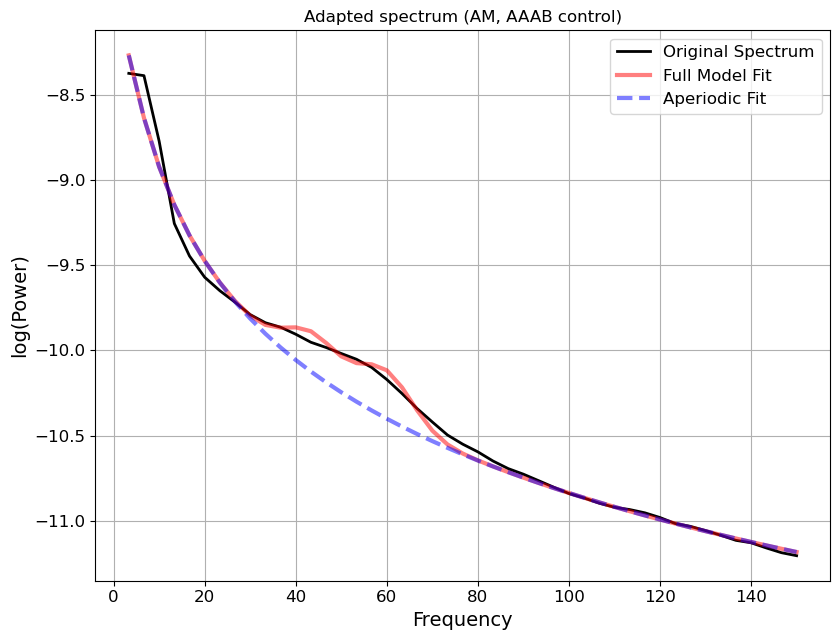

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8442, 17.2345, 1.9931                                     
                                                                                                  
                                       2 peaks were found:                                        
          

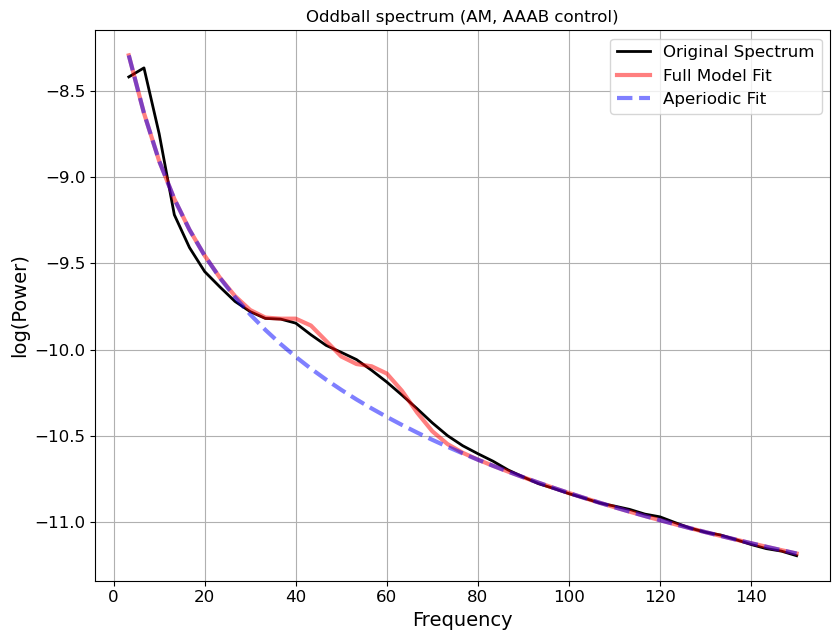

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8797, 21.2823, 1.9821                                     
                                                                                                  
                                       1 peaks were found:                                        
          

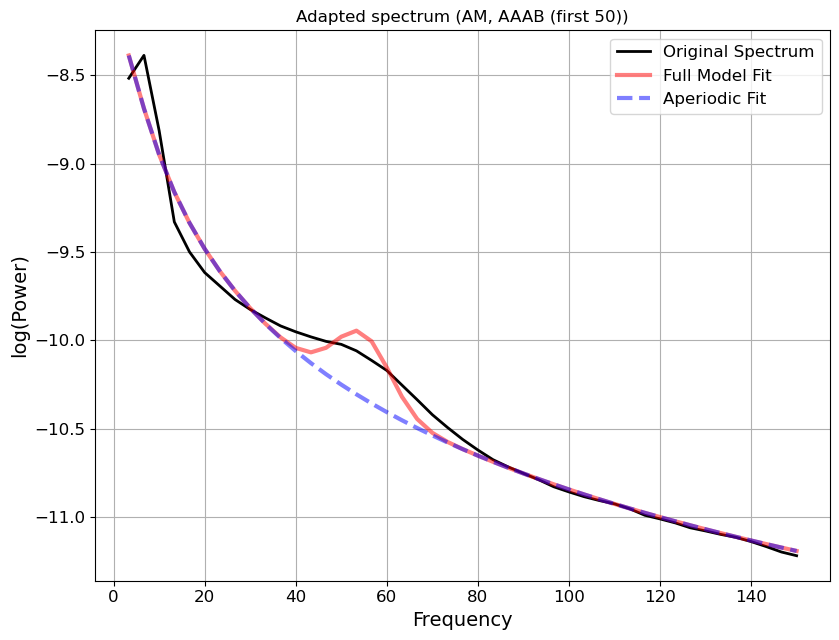

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7932, 26.2788, 2.0167                                     
                                                                                                  
                                       1 peaks were found:                                        
          

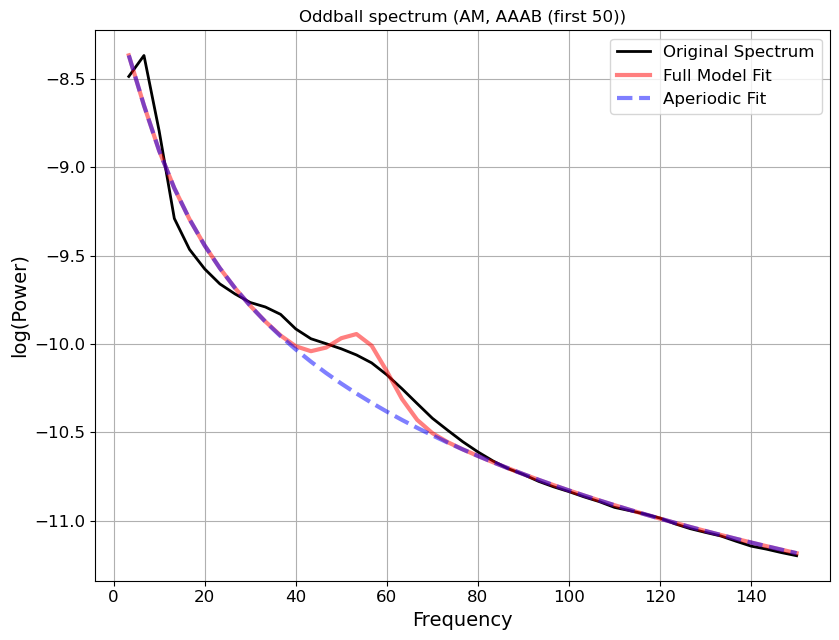

INFO:root:Applied FOOOF analysis to power spectra evoked by oddball stimulus in VISam


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.7906, 22.7924, 2.0196                                     
                                                                                                  
                                       1 peaks were found:                                        
          

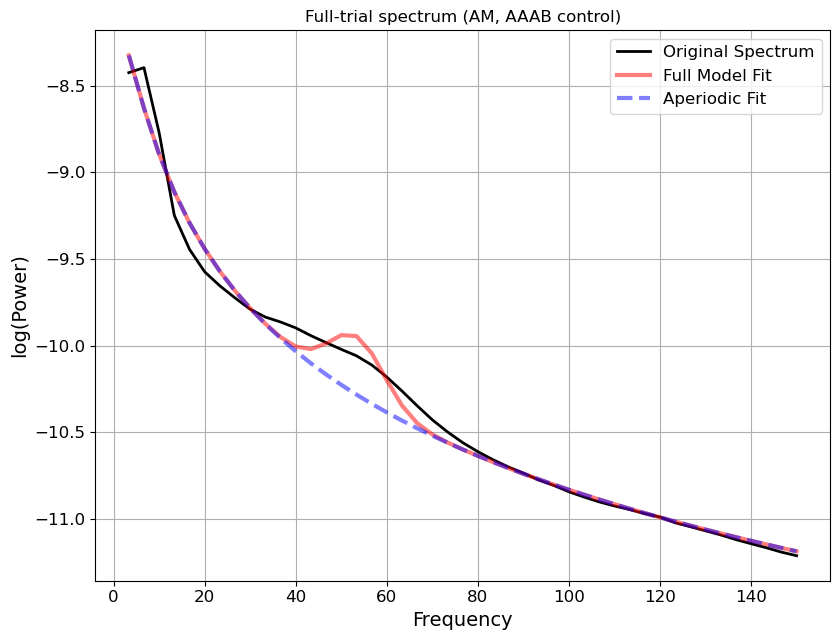

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -6.8638, 20.2185, 1.9935                                     
                                                                                                  
                                       1 peaks were found:                                        
          

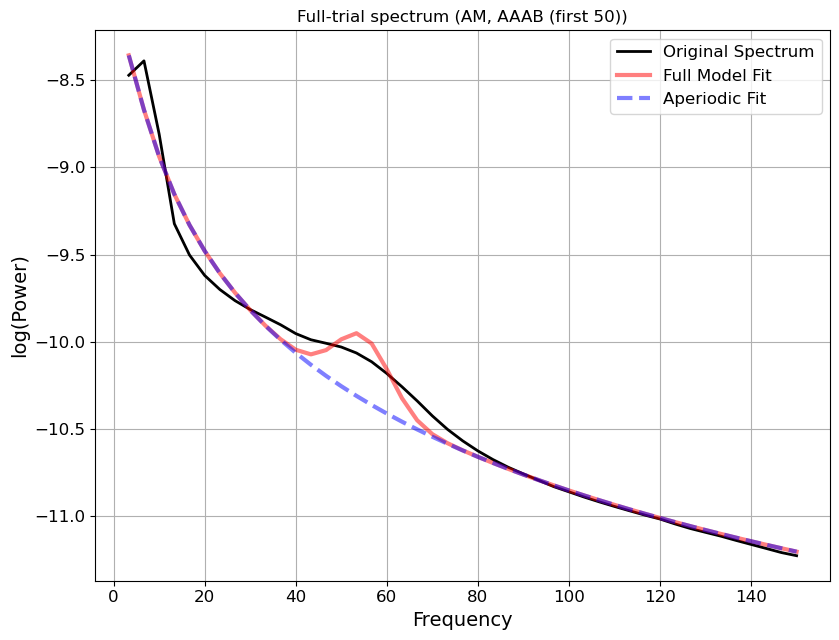

INFO:root:Applied FOOOF analysis to power spectra evoked by full trials in VISam
INFO:root:Applied FOOOF analysis to evoked power spectra for dd


In [16]:
for (name, condl, condr) in CONTRASTS:
    for area in ANATOMICAL_AREAS:
        fooof_stimulus_report(condl, area, "Adapted")
        fooof_stimulus_report(condl, area, "Oddball")

        fooof_stimulus_report(condr, area, "Adapted")
        fooof_stimulus_report(condr, area, "Oddball")

        logging.info("Applied FOOOF analysis to power spectra evoked by oddball stimulus in " + area)

        fooof_report(condl, area)
        fooof_report(condr, area)
        logging.info("Applied FOOOF analysis to power spectra evoked by full trials in " + area)
    logging.info("Applied FOOOF analysis to evoked power spectra for " + name)